# Neural Networks and Deep Learning A.Y. 2022/2023
## Final Project: 3D Objects Classification

Group members:<br>
* *Candon Matteo 2020353*: ICT for Internet and Multimedia (Cybersystems) <br>
* *Nicoletti Gianpietro 2053042*: ICT for Internet and Multimedia (Cybersystems) <br>
* *Rizzetto Nicola 2052417*: Computer Engineering (Artificial Intelligence and Robotics) <br>

## Initial configuration and import of the libraries

We suggest to run the code locally since the installing procedure could be quite long.

In [73]:
#Platform settings: this is an automatinc decision so, please, don't change the value
COLAB = True

try:
    from google.colab import drive
except:
    COLAB = False
    

##############Dataset settings##############

#True if you want to load a precomputed dataset 
LOAD_DATASET = True

#True if you have already the dataset in the memory
ALREADY_DOWNLOADED = False

#True if you have already unzipped the dataset in the ./data folder, IF True the value of 
#ALREADY_DOWNLOADED variable will be ignore
ALREADY_UNZIPPED = False

#Number of points in the dataset for each point cloud:
cloud_points = 2048 

#Number of classes in the dataset:
num_classes = 10

##############Model settings##############
LOAD_MODEL = True #True if you want load the trained models

In [14]:
#Usefull for better outputs visualization
PURPLE = '\033[95m'
CYAN = '\033[96m'
DARKCYAN = '\033[36m'
BLUE = '\033[94m'
GREEN = '\033[92m'
YELLOW = '\033[93m'
RED = '\033[91m'
BOLD = '\033[1m'
UNDERLINE = '\033[4m'
END = '\033[0m'

In [15]:
#if working with colab these are needed
if (COLAB):
    !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
    !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install git+https://github.com/pyg-team/pytorch_geometric.git


    !pip install tensorflow
    !pip install trimesh
    !pip install open3d

##############3D libraries##############
import trimesh # useful to load polygonal objects (off files)
import open3d


##############Neural Networks libraries##############
#used to download the dataset
import tensorflow as tf
from tensorflow import keras

import torch
import torch.nn as nn
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader


##############Graph libraries##############
from sklearn.neighbors import kneighbors_graph
import networkx as nx


##############Standard libraries##############
import seaborn as sn
import pandas as pd
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import time
import math
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer
import random

#manual set of seed for reproducibility
seed = 353
tf.random.set_seed(seed)


##############Utility and memory management libraries##############
from tqdm import tqdm, trange

import os
import glob
import gc
import collections
import urllib.request
import zipfile

## Utility functions definition

**NOTES**:

**In order to avoid missing classes you need to go to the directory where the dataset is and remove the unused file in the main directory of the dataset**

In [16]:
#usefull functions

def dataset(points = cloud_points):
    train_points = []
    train_labels = []
    test_points = []
    test_labels = []
    classes_map = {}
    
    #saving all classes' folder paths in list
    folders = [dir for dir in sorted(os.listdir(data_dir))if os.path.isdir(data_dir)]
    folders_path=[]
    for i in range(10):
        folders_path.append(glob.glob(os.path.join(data_dir, folders[i])))
        
        
    for i,folder in enumerate(folders_path):
        
        #storing classes' names into list
        
        print(i)
        print(folder[0])
        print(type(folder[0]))
        
        classes_map[i] = folder[0].split("\\")[-1]
        
        #storing train and test files
        train_files = glob.glob(os.path.join(folder[0], "train/*"))
        test_files = glob.glob(os.path.join(folder[0], "test/*"))
        
        #converting train and test files in cloud points
        for j in train_files:
            train_points.append(trimesh.load(j).sample(cloud_points))
            train_labels.append(i)

        for j in test_files:
            test_points.append(trimesh.load(j).sample(cloud_points))
            test_labels.append(i)

    return (np.array(train_points),
            np.array(test_points),
            np.array(train_labels),
            np.array(test_labels),
            classes_map)



def add_normals(points_array):
    
    tmp = []
    
    for i in trange(len(points_array)):
        pcd = open3d.geometry.PointCloud()
        pcd.points = open3d.utility.Vector3dVector(points_array[i])

        pcd.estimate_normals(search_param=open3d.geometry.KDTreeSearchParamHybrid(radius=250, max_nn=200))


        tmp.append(np.concatenate((np.asarray(pcd.points),np.asarray(pcd.normals)),axis=1).astype(np.float64))

    return tmp



def build_graph(data_points):
    
    edges = []
    
    for i in trange(len(data_points)):
        
        A = kneighbors_graph(data_points[i],mode='distance', n_neighbors = 50).toarray()
        indices = np.argpartition(A, 50, axis=1)[:, :50]
        edge_indexes = np.stack([np.repeat(np.arange(data_points[i].shape[0]), 50), indices.flatten()])
#         A = nx.from_numpy_array(A)
#         edges.append(np.asarray(list(A.edges())).T)
        edges.append(edge_indexes)
        print(edge_indexes.shape)
        
        del A
        del edge_indexes
        del indices
        gc.collect()
    
    return edges



def print_confusion_matrix_pandas(labels,predictions,title):
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=labels, y_pred=predictions)
    # Plot the confusion matrix as an image.
    class_names = label_ids.keys()
    df_cm = pd.DataFrame(cm, index = class_names, columns = class_names)
    plt.figure(figsize = (15,10))
    sn.heatmap(df_cm, annot=True, cmap='Blues')
    #plt.axis([-0.5, 13.5, 13.5, -0.5])
    plt.title(title,fontsize=20)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.savefig("./"+title+".png")
    plt.show()
    
    
    
def plot_images(data, labels, title, predictions=None):

    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(20, 20),subplot_kw=dict(projection='3d'))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    fig.suptitle(title,fontsize=30)
    
    k = 0
    for i in range(3):
        for j in range(3):
            pcd = open3d.geometry.PointCloud();
            pcd.points = open3d.utility.Vector3dVector(data[k][:,0:3]);
            pcd.normals = open3d.utility.Vector3dVector(data[k][:,3:6]);

            mesh = open3d.geometry.TriangleMesh.create_from_point_cloud_alpha_shape(pcd,5);
            mesh.compute_vertex_normals();
            
            vertices = np.asarray(mesh.vertices)
            faces = np.asarray(mesh.triangles)
            # Plot image.
            axes[i][j].scatter(data[k][:, 0], data[k][:, 1], data[k][:, 2],color='r')
            try:
                axes[i][j].plot_trisurf(vertices[:, 0], vertices[:, 1], vertices[:, 2], triangles=faces,alpha=0.3)
            except:
                print("")

            # Show true and predicted classes.
            if predictions is None:
                xlabel = "True: {0}".format(class_names[int(labels[k])])
            else:
                xlabel = "True: {0}, Pred: {1}".format(class_names[int(labels[k])], class_names[int(predictions[k])])
            axes[i][j].set_title(xlabel,fontsize=18)

            # Remove ticks from the plot.
            axes[i][j].set_xticks([])
            axes[i][j].set_yticks([])
            axes[i][j].set_zticks([])
            #axes[i][j].set_axis_off()
            
            k+=1
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.savefig("./"+title+".png")
    plt.show()

## Creating or loading the dataset

ModelNet10 with 2048 points: https://www.dropbox.com/s/t5h5nmphju4ni14/dataset_nndl_2048.zip?dl=1 <br>

**NOTES:**
* dl=1 : force the download of the file;
* In order to select the correct dataset you need only to modify the url in the method `urlretrieve(url,name)`;
* Remember to change the value of `cloud_points` according to the datasets you want use.

In [17]:
#this mapping is valid for the dataset downloaded from the link, we can not guarantee that this still valid for a new dataset
label_ids = {"bathtub": 0, "bed": 1, "chair" : 2, "desk" : 3, "dresser" : 4, "monitor" : 5, "night stand" : 6, "sofa" : 7,
             "table" : 8, "toilet" : 9}
class_names = {value:key for key, value in label_ids.items()}

In [18]:
if(LOAD_DATASET):
    
    if(not ALREADY_DOWNLOADED and (not ALREADY_UNZIPPED)):
        urllib.request.urlretrieve("https://www.dropbox.com/s/t5h5nmphju4ni14/dataset_nndl_2048.zip?dl=1", "dataset_nndl.zip")
        
    if(not ALREADY_UNZIPPED):
        with zipfile.ZipFile("dataset_nndl.zip", 'r') as zip_ref:
            zip_ref.extractall("./data/")
        
    #loading the data
    data_train = np.load("data/train_data.npy",allow_pickle=True)
    data_test = np.load("data/test_data.npy",allow_pickle=True)
    edge_train = np.load("data/train_edges.npy",allow_pickle=True)
    edge_test = np.load("data/test_edges.npy",allow_pickle=True)
    train_labels = np.load("data/train_labels.npy",allow_pickle=True)
    test_labels = np.load("data/test_labels.npy",allow_pickle=True)

In [19]:
if(not LOAD_DATASET):
    data_dir = tf.keras.utils.get_file("modelnet.zip", "http://3dvision.princeton.edu/projects/2014/3DShapeNets/ModelNet10.zip", extract = True)
    data_dir = os.path.join(os.path.dirname(data_dir), "ModelNet10")

#each class is already divided in train and test data

In [20]:
#Visualization of data example
if(not LOAD_DATASET):
    mesh = trimesh.load(os.path.join(data_dir,"chair/train/chair_0003.off"))
    mesh.show()

In [21]:
if(not LOAD_DATASET):
    classes = num_classes  #number of different kind of objects - non modifiable

    # Creating dataset object
    data_start_time = time.time()
    train_points, test_points, train_labels, test_labels, classes_map = dataset(cloud_points)
    data_end_time = time.time()

    print("Time spent creating the dataset object: ",np.round((data_end_time - data_start_time)/60,2), " minutes.")

In [22]:
if(not LOAD_DATASET):
    
    print(len(train_points))
    print(len(test_points))

    data_train = add_normals(train_points)
    data_test = add_normals(test_points)

    edge_train=build_graph(train_points)
    edge_test=build_graph(test_points)

    
    #removing usless variables to clean the RAM
    del train_points
    del test_points
    gc.collect()

**From now on the data contained in each point is: (X , Y , Z , $N_x$ , $N_y$ , $N_z$)** i.e: position + normal vector

### Saving the dataset into local memory

**NOTES:**

If you want create a link to be used in this code, compress the .npy files into a single .zip file.<br>
Make sure that the structure of the .zip will be:<br>
<br>
folder.zip<br>
--file1.npy<br>
--file2.npy<br>
-- ...<br>

<br>
and not something like:<br>
<br>
folder.zip<br>
--inner folder<br>
----file1.npy<br>
----file2.npy<br>
---- ...
<br>
<br>
Mantain these names:

* list of points for the train: train_data.npy
* list of points for the test: test_data.npy
* list of edges for the train: train_edges.npy
* list of edges for the test: test_edges.npy
* labels for the train: train_labels.npy
* labels for the test: test_labels.npy

In [23]:
if(not LOAD_DATASET):
    #list of arrays to array of arrays
    train = np.empty(len(edge_train), object)
    train[:] = edge_train
    test = np.empty(len(edge_test), object)
    test[:] = edge_test
    
    #saving the data
    np.save("data/train_data.npy",data_train)
    np.save("data/test_data.npy",data_test)
    np.save("data/train_edges.npy",train)
    np.save("data/test_edges.npy",test)
    np.save("data/train_labels.npy",train_labels)
    np.save("data/test_labels.npy",test_labels)

### Example of the dataset with and without normal vectors

table


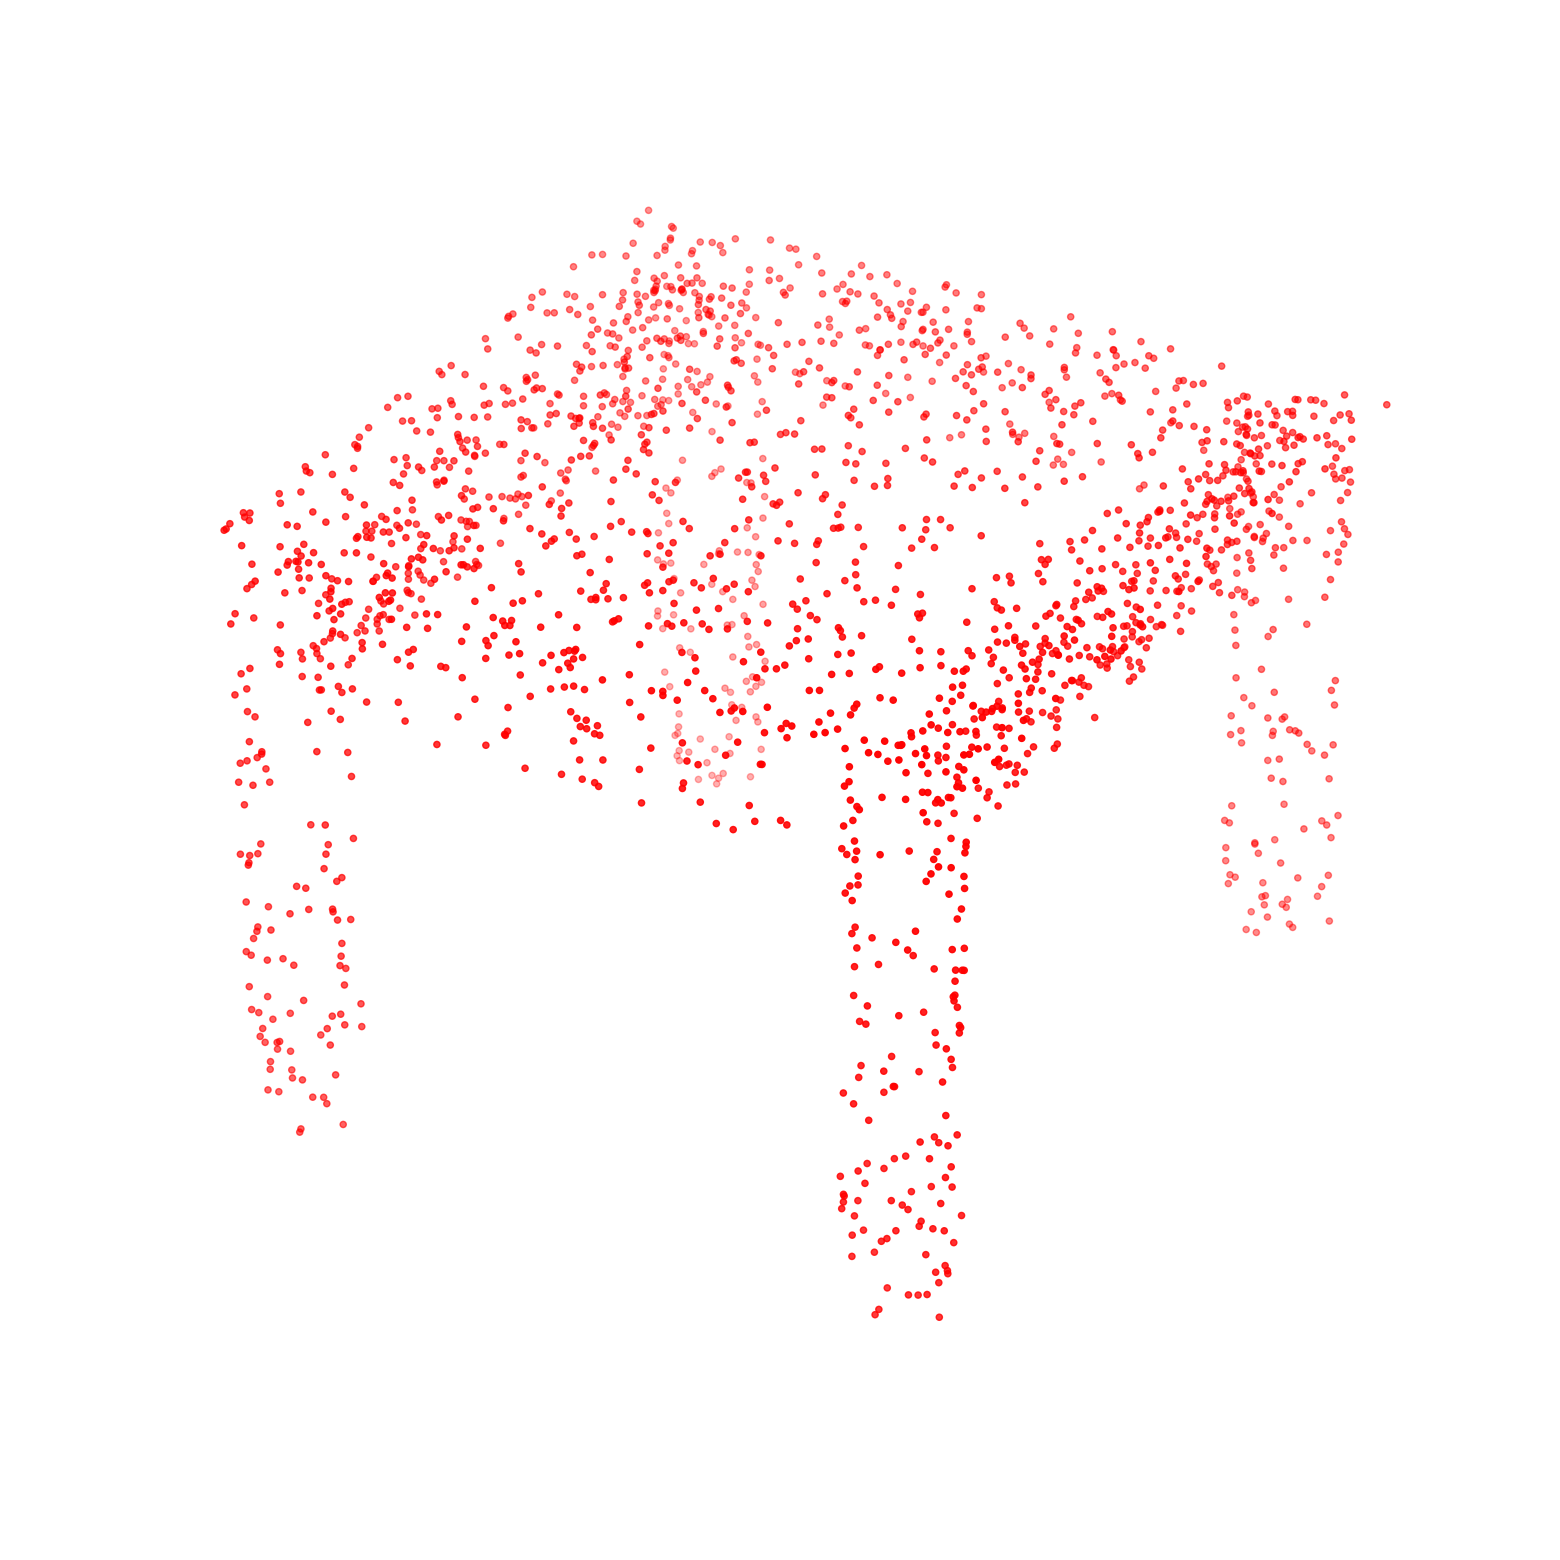

In [24]:
n = 3382
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(data_train[n][:, 0], data_train[n][:, 1], data_train[n][:, 2],color='r')
ax.set_axis_off()


print(class_names[train_labels[n]])

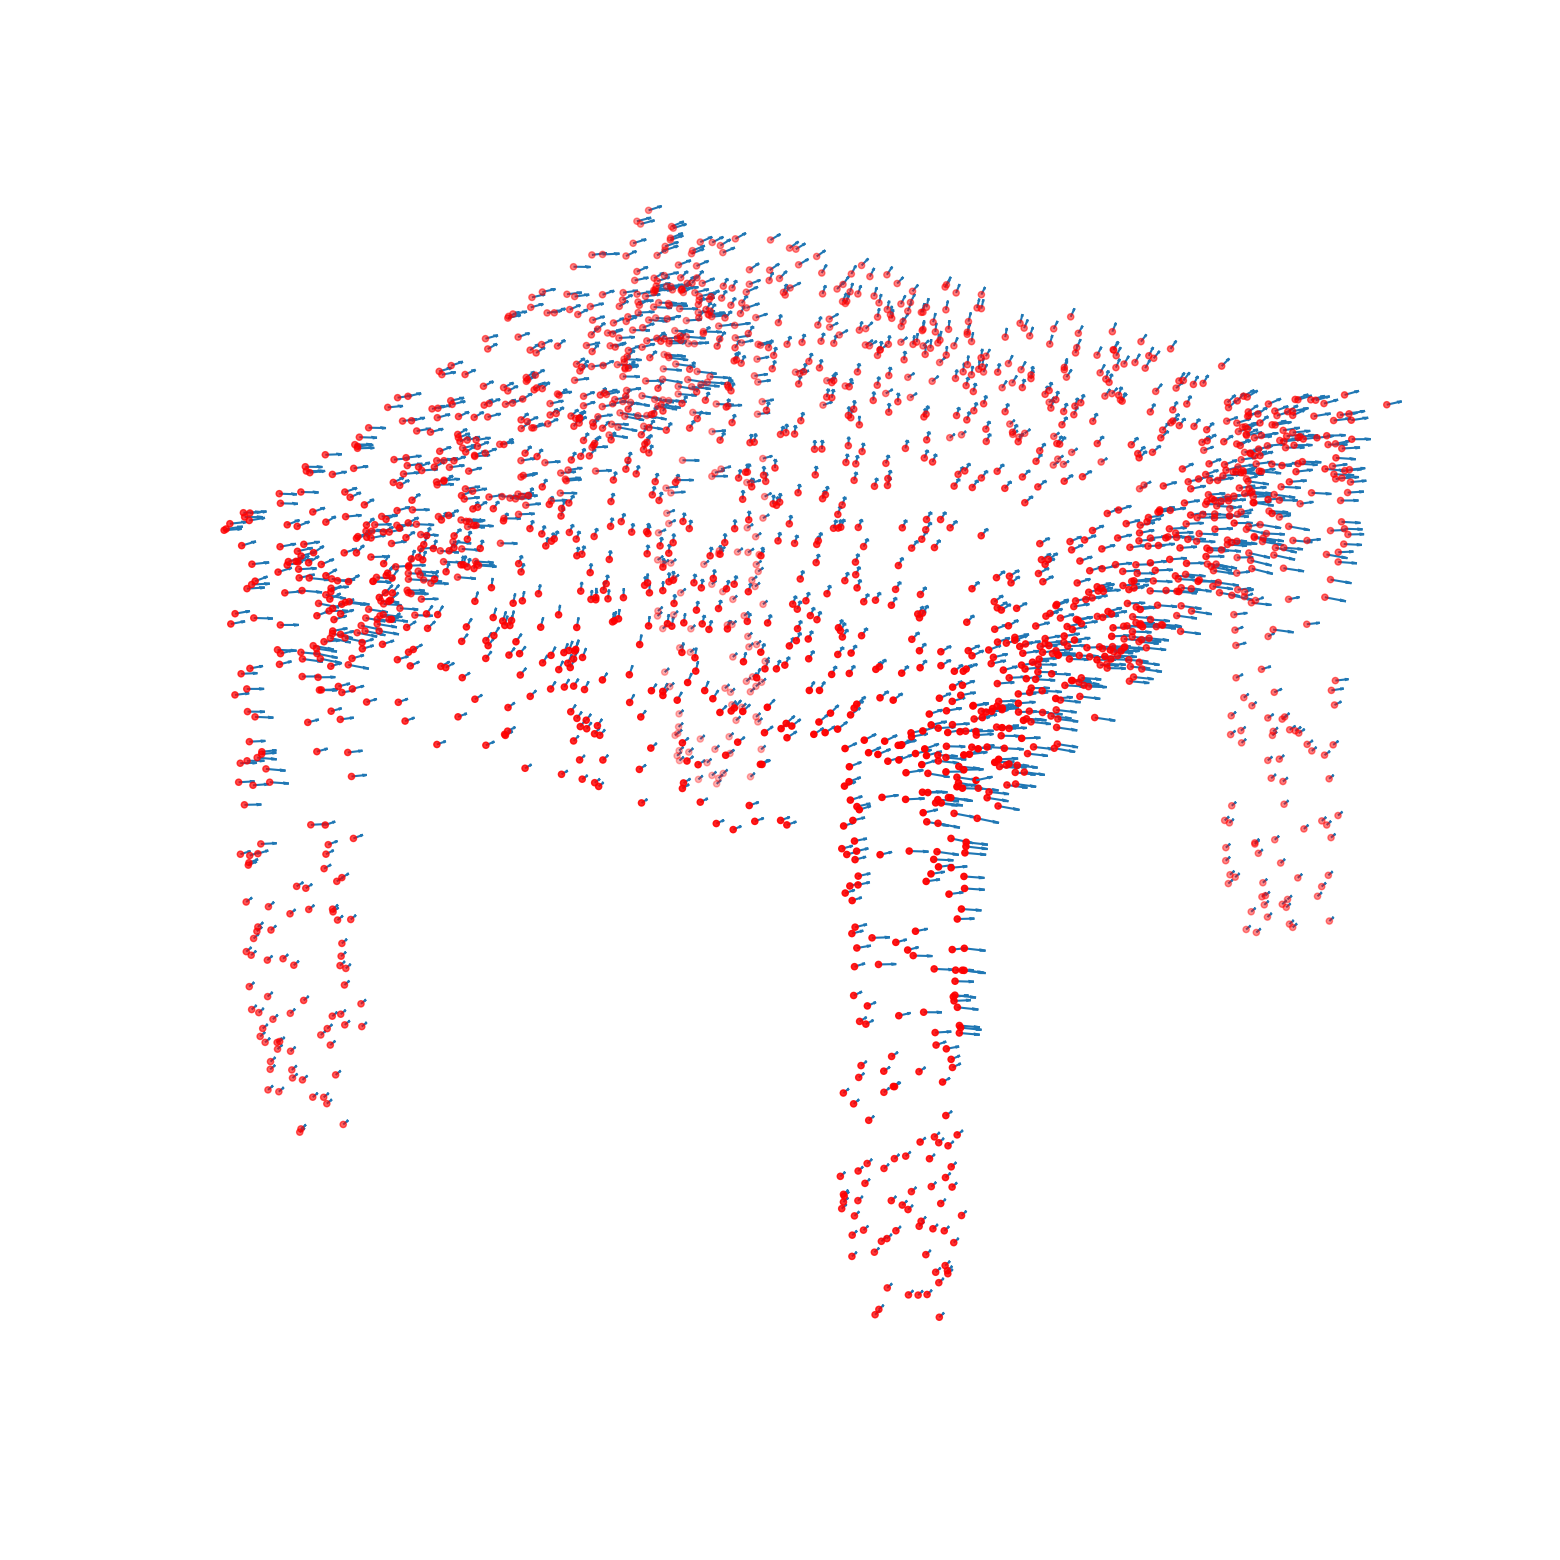

In [25]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(data_train[n][:, 0], data_train[n][:, 1], data_train[n][:, 2],color='r')
ax.set_axis_off()

for element in data_train[n]:
  x=element[0]
  y=element[1]
  z=element[2]
  u=abs(element[3])
  v=abs(element[4])
  w=abs(element[5])
  ax.quiver(x, y, z, u, v, w, length=0.5, normalize=True, alpha = 1)

## Graph Convolutional Network

### Shuffle and data augmentation

In [29]:
torch.cuda.empty_cache()
gc.collect()

41

In [30]:
#shuffle of the original data
indexes =[i for i in range(len(train_labels))]
random.shuffle(indexes)

data_train = data_train[indexes]
train_labels = train_labels[indexes]
edge_train = edge_train[indexes]

indexes =[i for i in range(len(test_labels))]
random.shuffle(indexes)

data_test = data_test[indexes]
test_labels = test_labels[indexes]
edge_test = edge_test[indexes]

In [31]:
#data augmentation: i.e. adding noise to the data(poistion + normal) but mainaining the same graph and label.
# in this case we obtain 3x samples of the original dataset
data_train_noise = np.concatenate((data_train,data_train+normal(0,5,size = (len(data_train),2048,6)),data_train+normal(0,10,size = (len(data_train),2048,6))),axis=0)
train_labels_noise = np.concatenate((train_labels,train_labels,train_labels),axis=0)
edge_train_noise =  np.concatenate((edge_train,edge_train,edge_train),axis=0)

In [32]:
#shuffle of the augmented dataset
indexes =[i for i in range(len(train_labels_noise))]
random.shuffle(indexes)

data_train_noise = data_train_noise[indexes]
train_labels_noise = train_labels_noise[indexes]
edge_train_noise = edge_train_noise[indexes]

In [44]:
# "one-hot encoding": in this case we want to maximize a specific position inside the array that rappresents the label of
#the sample. 
one_labels_train = []
for label in train_labels_noise:
    array = np.zeros(10)
    array[label] = 1000
    one_labels_train.append(array)

In [34]:
# Calculate the minimum and maximum values of each feature
min_values = np.min(data_train_noise, axis=0)
max_values = np.max(data_train_noise, axis=0)

# Normalize each feature by subtracting the minimum and dividing by the range
data_train_noise = (data_train_noise - min_values) / (max_values - min_values)

In [35]:
#normalizing the test dataset using the paramenter of the train
data_test = (data_test - min_values) / (max_values - min_values)

### Training and validation dataloaders

In [45]:
class ListDataset(Dataset):
    def __init__(self, data, edges, labels):
        self.data = data
        self.edges = edges
        self.labels = labels

    def __getitem__(self, index):
        return torch.tensor(self.data[index]), torch.tensor(self.edges[index]), torch.tensor(self.labels[index])

    def __len__(self):
        return len(self.data)

train_dataset = ListDataset(data_train_noise[0:10500], edge_train_noise[0:10500], one_labels_train[0:10500])
val_dataset = ListDataset(data_train_noise[10500:len(data_train_noise)], edge_train_noise[10500:len(data_train_noise)], one_labels_train[10500:len(data_train_noise)])


train_dataloader = DataLoader(train_dataset, batch_size = 1, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = 1, shuffle = False)

### Definition of the proposed model
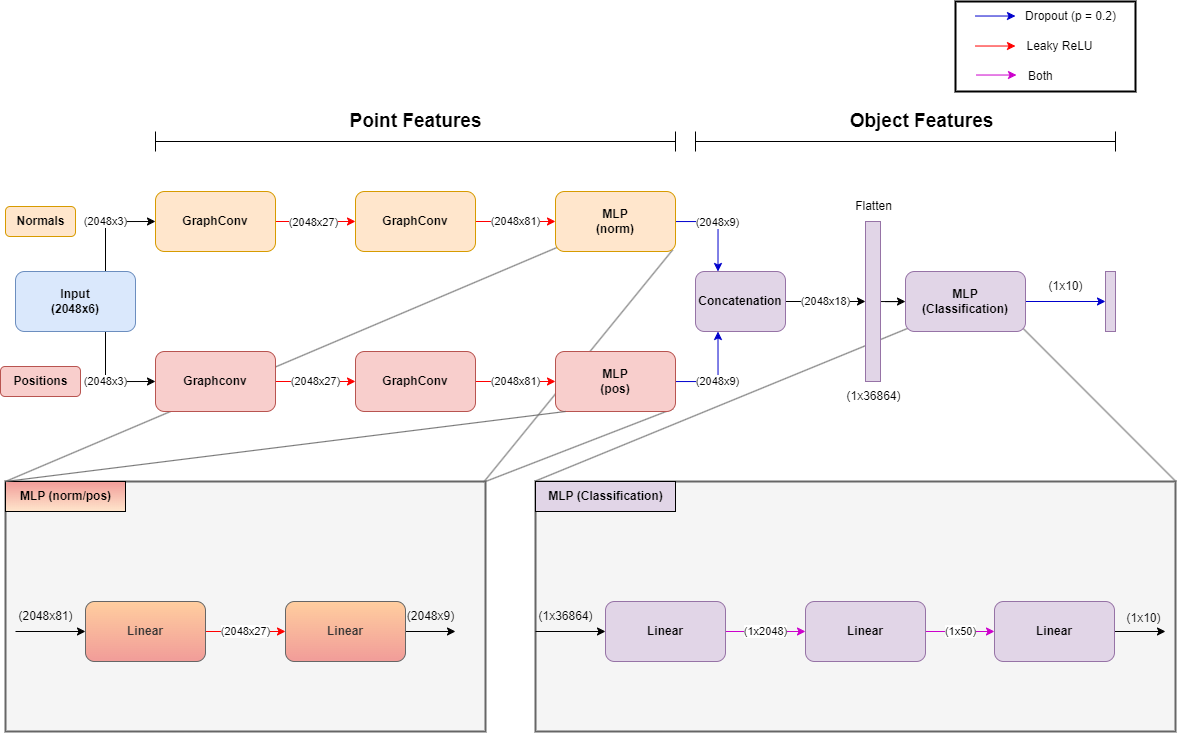

In [46]:
class MLPpos(torch.nn.Module):
    def __init__(self,):
        super().__init__()
        self.fc1 = nn.Linear(81, 27)
        self.fc2 = nn.Linear(27,9)
        self.act = nn.LeakyReLU()
    
        
    def forward(self, x):
       
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x
    
class MLPnorm(torch.nn.Module):
    def __init__(self,):
        super().__init__()
        
        self.fc1 = nn.Linear(81, 27)
        self.fc2 = nn.Linear(27,9)
        self.act = nn.LeakyReLU()
    
        
    def forward(self, x):
        
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        
        return x

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()

        # Define the graph convolutional layers
        self.conv1 = GCNConv(3, 27)
        self.conv2 = GCNConv(27, 81)
       
        
        self.conv3 = GCNConv(3, 27)
        self.conv4 = GCNConv(27, 81)
        
        #compressing the point features
        self.mlppos = MLPpos()
        self.mlpnorm = MLPnorm()
        
        # Define the final fully-connected layer
        self.fc1 = nn.Linear(18*cloud_points,cloud_points)
        self.fc2 = nn.Linear(cloud_points,50)
        self.fc3 = nn.Linear(50,num_classes)
        
        self.relu = nn.LeakyReLU()
        self.drop = nn.Dropout(p=0.2)
        self.out= nn.Softmax()
        
    def forward(self, x, edge_index):
        # Apply the graph convolutional layers
        
        pos = self.relu(self.conv1(x[:,0:3],edge_index))
        pos = self.relu(self.conv2(pos,edge_index))
        pos = self.drop(self.mlppos(pos))
        
        norm = self.relu(self.conv3(x[:,3:6],edge_index))
        norm = self.relu(self.conv4(norm,edge_index))
        norm = self.drop(self.mlpnorm(norm))
        
        # Apply the final fully-connected layer
        xl = torch.cat((pos,norm), 1)
        xl = torch.flatten(xl)
        xl = self.relu(self.drop(self.fc1(xl)))
        xl = self.relu(self.drop(self.fc2(xl)))
        xl = self.drop(self.fc3(xl))
        
        return xl


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net =  Net(num_classes=10).to(device)

print(BOLD+"You are working on: "+END+str(device))

You are working on: cuda


### Training procedure

In [48]:
#training only if you decide to not load the model    
loss_fn = nn.MSELoss()
if(not LOAD_MODEL):
    
    num_epochs = 30
    

    optimizer = optim.RMSprop(net.parameters(), lr=0.001, weight_decay=1e-2)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

    #lists to store the trend of the learning procedure
    plot_train = []
    plot_val=[]


    best_epoch_val = 0
    prev_loss_val = np.inf

    best_epoch_train = 0
    prev_loss_train = np.inf

    count_epochs = 0 #counts the epoch since we consider the fact we can manually interrupct the 
                     #training procedure(used for the plots)

    for epoch in range(num_epochs):

        print('#################')
        print(f'# EPOCH {epoch+1}')
        print('#################')



        #lists to store the trend of the learning procedure "in real time" at each epoch/batch
        train_loss = []
        val_loss = []
        batch_loss = []

        ##############TRAINING##############

        net.train()

        input_counter = 0
        counter = 0

        optimizer.zero_grad()

        iterator = tqdm(train_dataloader)    
        for sample in iterator:
            data = sample[0][0].float().to(device)
            edges = sample[1][0].long().to(device)
            labels = sample[2].float().to(device)

            out = net(data, edges)


            loss = loss_fn(labels[0], out)
            loss.backward()

            # Update the weights every 20 inputs:
            #  - accumulating the gradient
            #  - computing the mean
            #  - updating the weights
            #  - reseting the gradient to 0

            input_counter+=1 #number of inputs until now in the current epoch
            counter +=1 #number of inputs after the last update in the current epoch

            batch_loss.append(loss.detach().cpu().numpy()) #used to display the loss in the output

            if input_counter % 20 == 0 or input_counter == len(one_labels_train):

                #computing the mean of the gradient after counter input
                #we used two counters to consider the (possible) different dimension of the last batch:
                #  - input_counter: used to check if the inputs in the 20th and to check if we reach the last iteration
                #  - counter: count the input between two updates ad it's used to compute the mean

                for p in net.parameters():
                    p.grad /= counter

                optimizer.step()
                optimizer.zero_grad() 
                iterator.set_description(f"Train loss: {np.array(batch_loss).mean()}")
                batch_loss = []
                counter = 0

            train_loss.append(loss.detach().cpu().numpy())

        gc.collect()

        scheduler.step() #one epoch done!

        plot_train.append(np.mean(train_loss))

        ##############VALIDATION##############

        net.eval()
        iterator = tqdm(val_dataloader)
        for sample in iterator:
            iterator.set_description("Validation phase")
            data = sample[0][0].float().to(device)
            edges = sample[1][0].long().to(device)
            labels = sample[2].float().to(device)

            out = net(data, edges)

            loss = loss_fn(labels[0], out)

            val_loss.append(loss.detach().cpu().numpy())

        print(BOLD+"AVERAGE TRAINING LOSS: "+END+str(np.mean(train_loss)))
        print(BOLD+"AVERAGE VALIDATION LOSS: " +END+str(np.mean(val_loss))+"\n")

        plot_val.append(np.mean(val_loss))

        #saving the best model according to the training loss
        if np.mean(train_loss) < prev_loss_train:
            print(GREEN+"Saved Model: "+END+UNDERLINE+"best training error reached"+END)
            best_epoch_train = epoch + 1
            torch.save(net.state_dict(), "model_bestTRAIN.pt")
            prev_loss_train = np.mean(train_loss)


        #saving the best model according to the validation loss
        if np.mean(val_loss) < prev_loss_val:
            print(GREEN+"Saved Model: "+END+UNDERLINE+"best validation error reached\n\n"+END)
            best_epoch_val = epoch + 1
            torch.save(net.state_dict(), "model_bestVAL.pt")
            prev_loss_val = np.mean(val_loss)
        else:
            print("\n\n")

        gc.collect()

        #next epoch
        count_epochs += 1

#################
# EPOCH 1
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 77.62it/s]


AVERAGE TRAINING LOSS: 90318.49
AVERAGE VALIDATION LOSS: 87432.52

Saved Model: best training error reached
Saved Model: best validation error reached


#################
# EPOCH 2
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:19<00:00, 76.91it/s]


AVERAGE TRAINING LOSS: 89693.35
AVERAGE VALIDATION LOSS: 87919.055

Saved Model: best training error reached



#################
# EPOCH 3
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 78.23it/s]


AVERAGE TRAINING LOSS: 89512.695
AVERAGE VALIDATION LOSS: 87179.59

Saved Model: best training error reached
Saved Model: best validation error reached


#################
# EPOCH 4
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 78.35it/s]


AVERAGE TRAINING LOSS: 89567.46
AVERAGE VALIDATION LOSS: 87537.93




#################
# EPOCH 5
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 79.69it/s]


AVERAGE TRAINING LOSS: 89487.1
AVERAGE VALIDATION LOSS: 87148.89

Saved Model: best training error reached
Saved Model: best validation error reached


#################
# EPOCH 6
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 79.26it/s]


AVERAGE TRAINING LOSS: 88669.32
AVERAGE VALIDATION LOSS: 85410.52

Saved Model: best training error reached
Saved Model: best validation error reached


#################
# EPOCH 7
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 78.29it/s]


AVERAGE TRAINING LOSS: 88394.61
AVERAGE VALIDATION LOSS: 85316.195

Saved Model: best training error reached
Saved Model: best validation error reached


#################
# EPOCH 8
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 79.62it/s]


AVERAGE TRAINING LOSS: 87396.68
AVERAGE VALIDATION LOSS: 83750.49

Saved Model: best training error reached
Saved Model: best validation error reached


#################
# EPOCH 9
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 79.51it/s]


AVERAGE TRAINING LOSS: 85355.24
AVERAGE VALIDATION LOSS: 88482.234

Saved Model: best training error reached



#################
# EPOCH 10
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 78.69it/s]


AVERAGE TRAINING LOSS: 81397.414
AVERAGE VALIDATION LOSS: 86638.016

Saved Model: best training error reached



#################
# EPOCH 11
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 78.29it/s]


AVERAGE TRAINING LOSS: 72667.414
AVERAGE VALIDATION LOSS: 82887.305

Saved Model: best training error reached
Saved Model: best validation error reached


#################
# EPOCH 12
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 77.66it/s]


AVERAGE TRAINING LOSS: 70886.7
AVERAGE VALIDATION LOSS: 82869.56

Saved Model: best training error reached
Saved Model: best validation error reached


#################
# EPOCH 13
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 79.13it/s]


AVERAGE TRAINING LOSS: 69244.664
AVERAGE VALIDATION LOSS: 82728.11

Saved Model: best training error reached
Saved Model: best validation error reached


#################
# EPOCH 14
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 80.02it/s]


AVERAGE TRAINING LOSS: 68381.64
AVERAGE VALIDATION LOSS: 82651.39

Saved Model: best training error reached
Saved Model: best validation error reached


#################
# EPOCH 15
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 80.05it/s]


AVERAGE TRAINING LOSS: 67260.93
AVERAGE VALIDATION LOSS: 82870.34

Saved Model: best training error reached



#################
# EPOCH 16
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 80.70it/s]


AVERAGE TRAINING LOSS: 66294.805
AVERAGE VALIDATION LOSS: 86115.4

Saved Model: best training error reached



#################
# EPOCH 17
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 80.49it/s]


AVERAGE TRAINING LOSS: 65670.06
AVERAGE VALIDATION LOSS: 82920.414

Saved Model: best training error reached



#################
# EPOCH 18
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 79.98it/s]


AVERAGE TRAINING LOSS: 64394.215
AVERAGE VALIDATION LOSS: 83512.71

Saved Model: best training error reached



#################
# EPOCH 19
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 79.61it/s]


AVERAGE TRAINING LOSS: 63089.688
AVERAGE VALIDATION LOSS: 84918.79

Saved Model: best training error reached



#################
# EPOCH 20
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 78.78it/s]


AVERAGE TRAINING LOSS: 62111.586
AVERAGE VALIDATION LOSS: 83531.984

Saved Model: best training error reached



#################
# EPOCH 21
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 79.19it/s]


AVERAGE TRAINING LOSS: 60818.28
AVERAGE VALIDATION LOSS: 82872.46

Saved Model: best training error reached



#################
# EPOCH 22
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 79.32it/s]


AVERAGE TRAINING LOSS: 60451.316
AVERAGE VALIDATION LOSS: 82830.21

Saved Model: best training error reached



#################
# EPOCH 23
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 79.76it/s]


AVERAGE TRAINING LOSS: 60911.38
AVERAGE VALIDATION LOSS: 83038.79




#################
# EPOCH 24
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 79.55it/s]


AVERAGE TRAINING LOSS: 60660.76
AVERAGE VALIDATION LOSS: 82902.99




#################
# EPOCH 25
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 79.84it/s]


AVERAGE TRAINING LOSS: 59880.465
AVERAGE VALIDATION LOSS: 82919.92

Saved Model: best training error reached



#################
# EPOCH 26
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 79.47it/s]


AVERAGE TRAINING LOSS: 59607.45
AVERAGE VALIDATION LOSS: 82986.59

Saved Model: best training error reached



#################
# EPOCH 27
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 78.31it/s]


AVERAGE TRAINING LOSS: 59960.09
AVERAGE VALIDATION LOSS: 82796.21




#################
# EPOCH 28
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 79.11it/s]


AVERAGE TRAINING LOSS: 59416.02
AVERAGE VALIDATION LOSS: 82865.6

Saved Model: best training error reached



#################
# EPOCH 29
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 79.68it/s]


AVERAGE TRAINING LOSS: 59546.918
AVERAGE VALIDATION LOSS: 82935.664




#################
# EPOCH 30
#################


Validation phase: 100%|████████████████████████████████████████████████████████████| 1473/1473 [00:18<00:00, 79.91it/s]


AVERAGE TRAINING LOSS: 59604.742
AVERAGE VALIDATION LOSS: 82891.58






#### Saving the result or downloading of the model

Files:
* Results: https://www.dropbox.com/s/l644jbyue0snxl6/results_nndl.zip?dl=1
* Models: https://www.dropbox.com/s/c30ulmip77tg54u/models_nndl.zip?dl=1

In [49]:
#saving the results into arrays
if(not LOAD_MODEL):
    
    np.save("./data/plot_train.npy",np.array(plot_train))
    np.save("./data/plot_val.npy",np.array(plot_val))
    np.save("./data/best_epochs.npy",np.array([best_epoch_train,best_epoch_val,count_epochs]))
    np.save("./data/best_losses.npy",np.array([prev_loss_train,prev_loss_val]))

#loading the results mantaining the same variable names
else:
    urllib.request.urlretrieve("https://www.dropbox.com/s/l644jbyue0snxl6/results_nndl.zip?dl=1", "results_nndl.zip")
    urllib.request.urlretrieve("https://www.dropbox.com/s/c30ulmip77tg54u/models_nndl.zip?dl=1", "models_nndl.zip")
       
    with zipfile.ZipFile("results_nndl.zip", 'r') as zip_ref:
        zip_ref.extractall("./data/")
    
    with zipfile.ZipFile("models_nndl.zip", 'r') as zip_ref:
        zip_ref.extractall("./")
    
    plot_train = np.load("data/plot_train.npy",allow_pickle=True)
    plot_val = np.load("data/plot_val.npy",allow_pickle=True)
    best_epochs = np.load("data/best_epochs.npy",allow_pickle=True) 
    best_losses = np.load("data/best_losses.npy",allow_pickle=True)
    
    best_epoch_train = best_epochs[0]
    best_epoch_val = best_epochs[1]
    count_epochs = best_epochs[2]
    
    prev_loss_train = best_losses[0]
    prev_loss_val = best_losses[1]

#### Plot of the losses

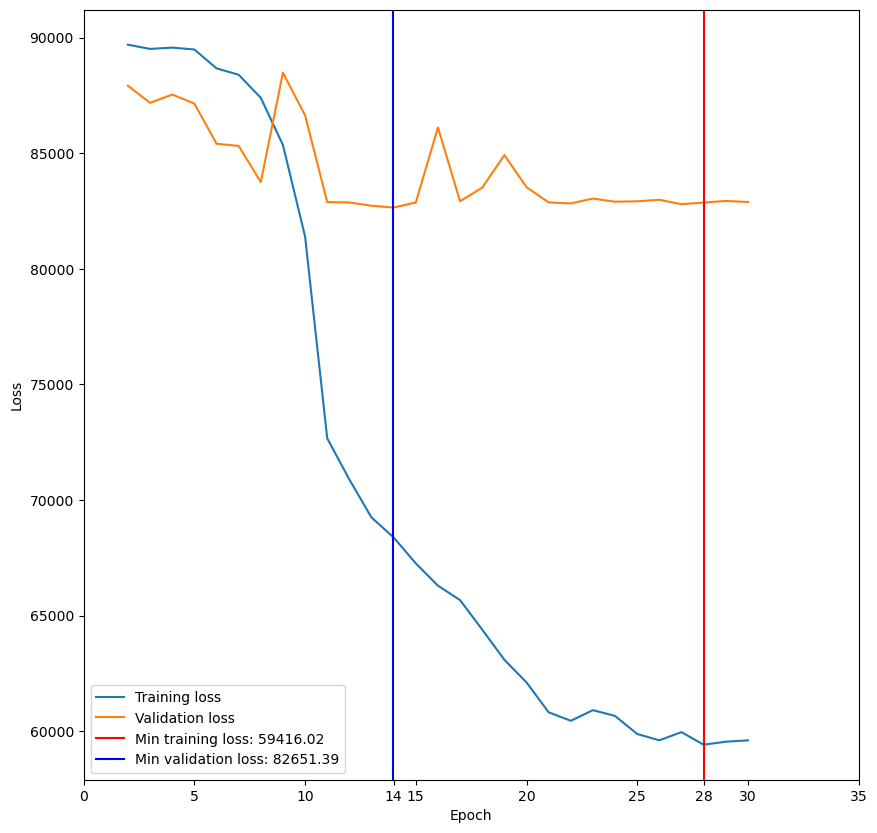

In [50]:
#generating the batch indexes
batchID = np.array([i for i in range(count_epochs)])+np.ones(count_epochs)

plt.figure(figsize=(10,10))

#plotting the losses
plt.plot(batchID[1:],plot_train[1:],label = "Training loss")
plt.plot(batchID[1:],plot_val[1:], label = "Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

#showing the position of the best values
plt.axvline(x = best_epoch_train+0.02, color = 'r', label = "Min training loss: "+str(prev_loss_train))
plt.axvline(x = best_epoch_val-0.02, color = 'b', label = "Min validation loss: "+str(prev_loss_val))

#adding the position of the best values in the x axis
ticks = list(plt.xticks()[0]) 
ticks.extend([best_epoch_train,best_epoch_val])
plt.xticks(ticks)

plt.legend()

#saving the figure
plt.savefig("Training procedure")
plt.show()

### Testing and final results

Since, during the training phase, we compute the train loss with the dropout enabled, we want to compare the value of the losses with the `eval()` mode enabled.<br>
Moreover we need to compare the losses and the accuracy **withoout the noisy data** inside the datasets and the accuracy.

NOTE:<br>
**If you decide to download the trained model the dataloaders will containd data with different noise so the results will be different.**

#### Best model (training error)

In [54]:
best_model_train =  Net(num_classes=10).to(device)
best_model_train.load_state_dict(torch.load("model_bestTRAIN.pt"))
best_model_train.eval();

In [55]:
train_loss_final = []
val_loss_final = []

iterator =  tqdm(train_dataloader)
for sample in iterator:
    iterator.set_description("Final train loss")
    data = sample[0][0].float().to(device)
    edges = sample[1][0].long().to(device)
    labels = sample[2].float().to(device)

    out = best_model_train(data, edges)

    loss = loss_fn(labels[0], out)

    train_loss_final.append(loss.detach().cpu().numpy())
    
iterator =  tqdm(val_dataloader)
for sample in iterator:
    iterator.set_description("Final validation loss")
    data = sample[0][0].float().to(device)
    edges = sample[1][0].long().to(device)
    labels = sample[2].float().to(device)

    out = best_model_train(data, edges)

    loss = loss_fn(labels[0], out)

    val_loss_final.append(loss.detach().cpu().numpy())
        
print(BOLD+"FINAL AVERAGE TRAINING LOSS: "+END+str(np.mean(train_loss_final)))
print(BOLD+"FINAL AVERAGE VALIDATION LOSS: " +END+str(np.mean(val_loss_final))+"\n")

Final validation loss: 100%|███████████████████████████████████████████████████████| 1473/1473 [00:20<00:00, 73.51it/s]

FINAL AVERAGE TRAINING LOSS: 49438.086
FINAL AVERAGE VALIDATION LOSS: 82865.6



In [56]:
correct_train = np.zeros(len(train_labels))
predictions = []
losses_train = []

for i in trange(len(correct_train)):
    
    #"one-hot encoded"
    array = np.zeros(10)
    array[train_labels[i]] = 1000
    label = torch.tensor(array).float().to(device)
    
    out = best_model_train(torch.tensor(data_train[i]).float().to(device),torch.tensor(edge_train[i]).long().to(device))
    
    predictions.append(torch.argmax(out).item())
    
    loss = loss_fn(label, out)
    losses_train.append(loss.detach().cpu().numpy())
    
    if(train_labels[i] == torch.argmax(out).item()):
        correct_train[i] = 1
        
print(BOLD+"Train loss (without noisy data): " + END + str(np.array(losses_train).mean()))
print(BOLD+"Train accuracy: " + END + str(correct_train.mean()*100)+"%")

100%|██████████████████████████████████████████████████████████████████████████████| 3991/3991 [00:41<00:00, 97.27it/s]

Train loss (without noisy data): 13224480000.0
Train accuracy: 22.425457278877474%


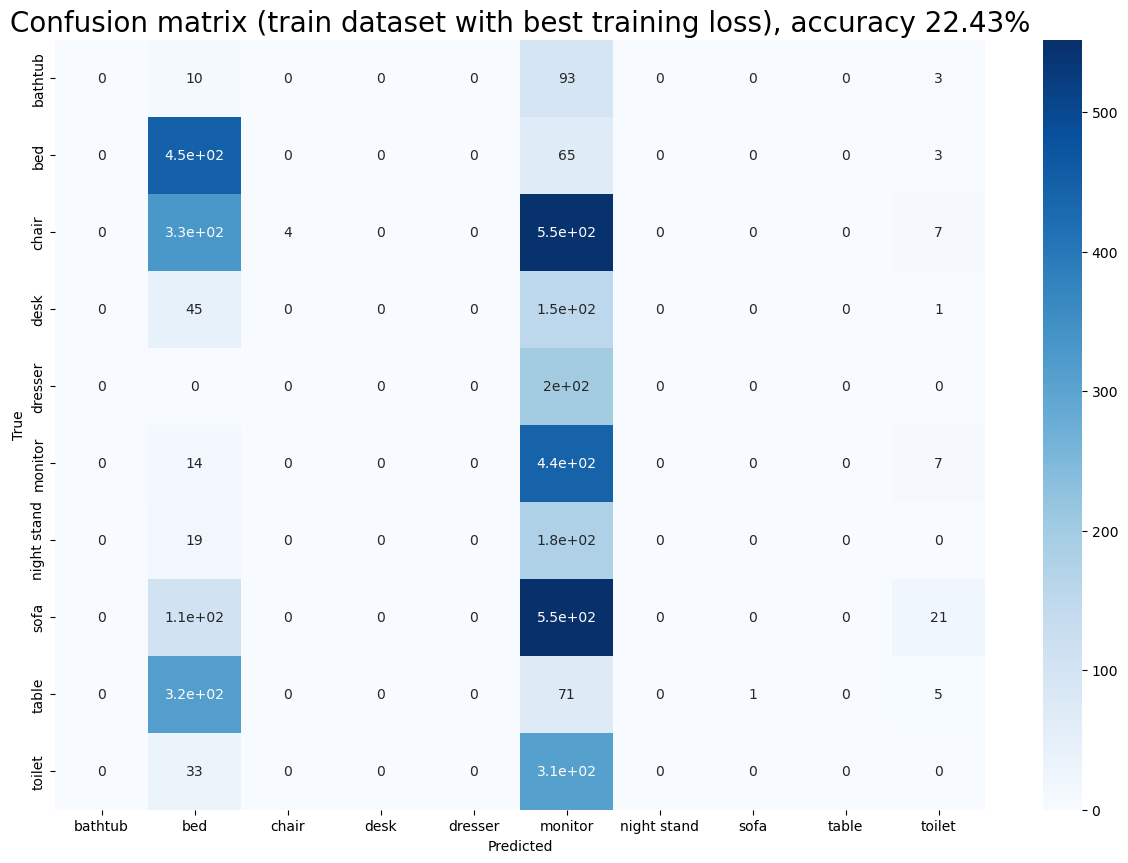

In [57]:
print_confusion_matrix_pandas(labels = train_labels, predictions = predictions, 
                              title = f"Confusion matrix (train dataset with best training loss), accuracy {np.round(correct_train.mean()*100,2)}%")

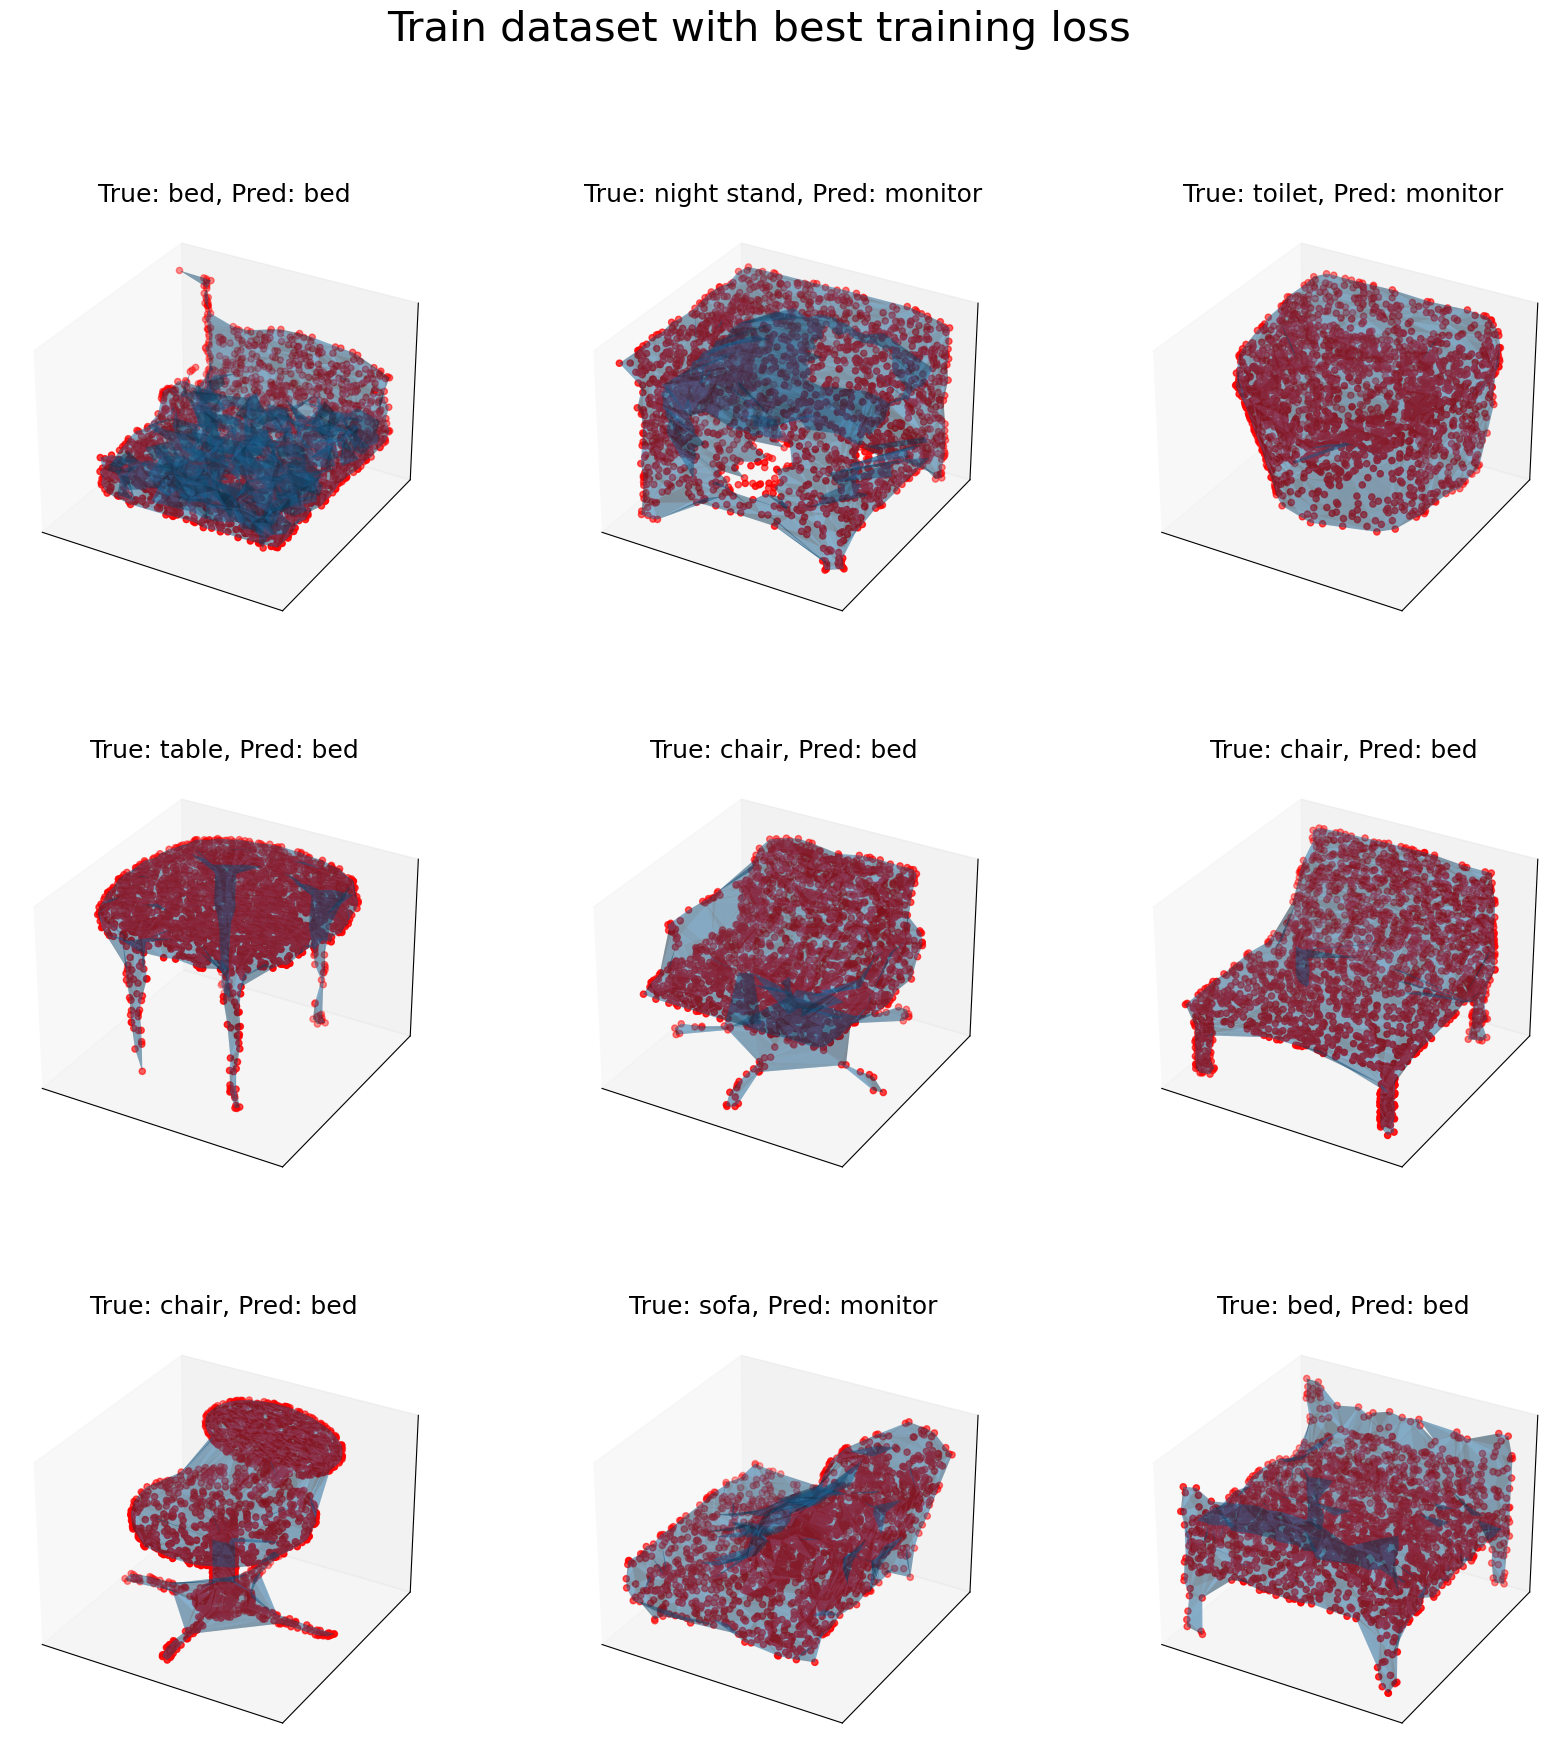

In [58]:
plot_images(data_train, train_labels, title = "Train dataset with best training loss", predictions=predictions)

In [59]:
correct_test = np.zeros(len(test_labels))
predictions = []
losses_test = []

for i in trange(len(correct_test)):
    
    #"one-hot encoded"
    array = np.zeros(10)
    array[test_labels[i]] = 1000
    label = torch.tensor(array).float().to(device)
    
    out = best_model_train(torch.tensor(data_test[i]).float().to(device),torch.tensor(edge_test[i]).long().to(device))
    
    predictions.append(torch.argmax(out).item())
    
    loss = loss_fn(label, out)
    losses_test.append(loss.detach().cpu().numpy())
    
    if(test_labels[i] == torch.argmax(out).item()):
        correct_test[i] = 1

print(BOLD+"Test loss: " + END + str(np.array(losses_test).mean()))
print(BOLD+"Test accuracy: "+END+str(correct_test.mean()*100)+"%")

100%|████████████████████████████████████████████████████████████████████████████████| 908/908 [00:12<00:00, 71.67it/s]

Test loss: 76927.016
Test accuracy: 32.48898678414097%


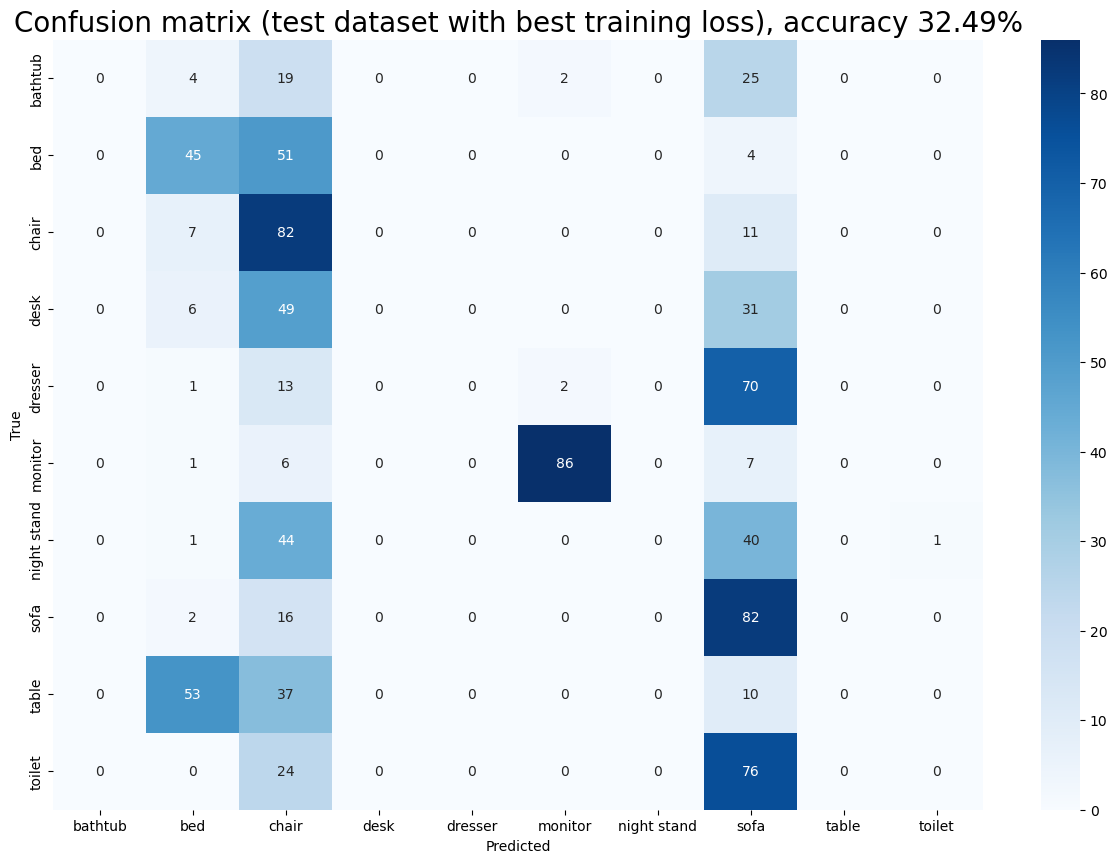

In [60]:
print_confusion_matrix_pandas(labels = test_labels, predictions = predictions, 
                              title = f"Confusion matrix (test dataset with best training loss), accuracy {np.round(correct_test.mean()*100,2)}%")

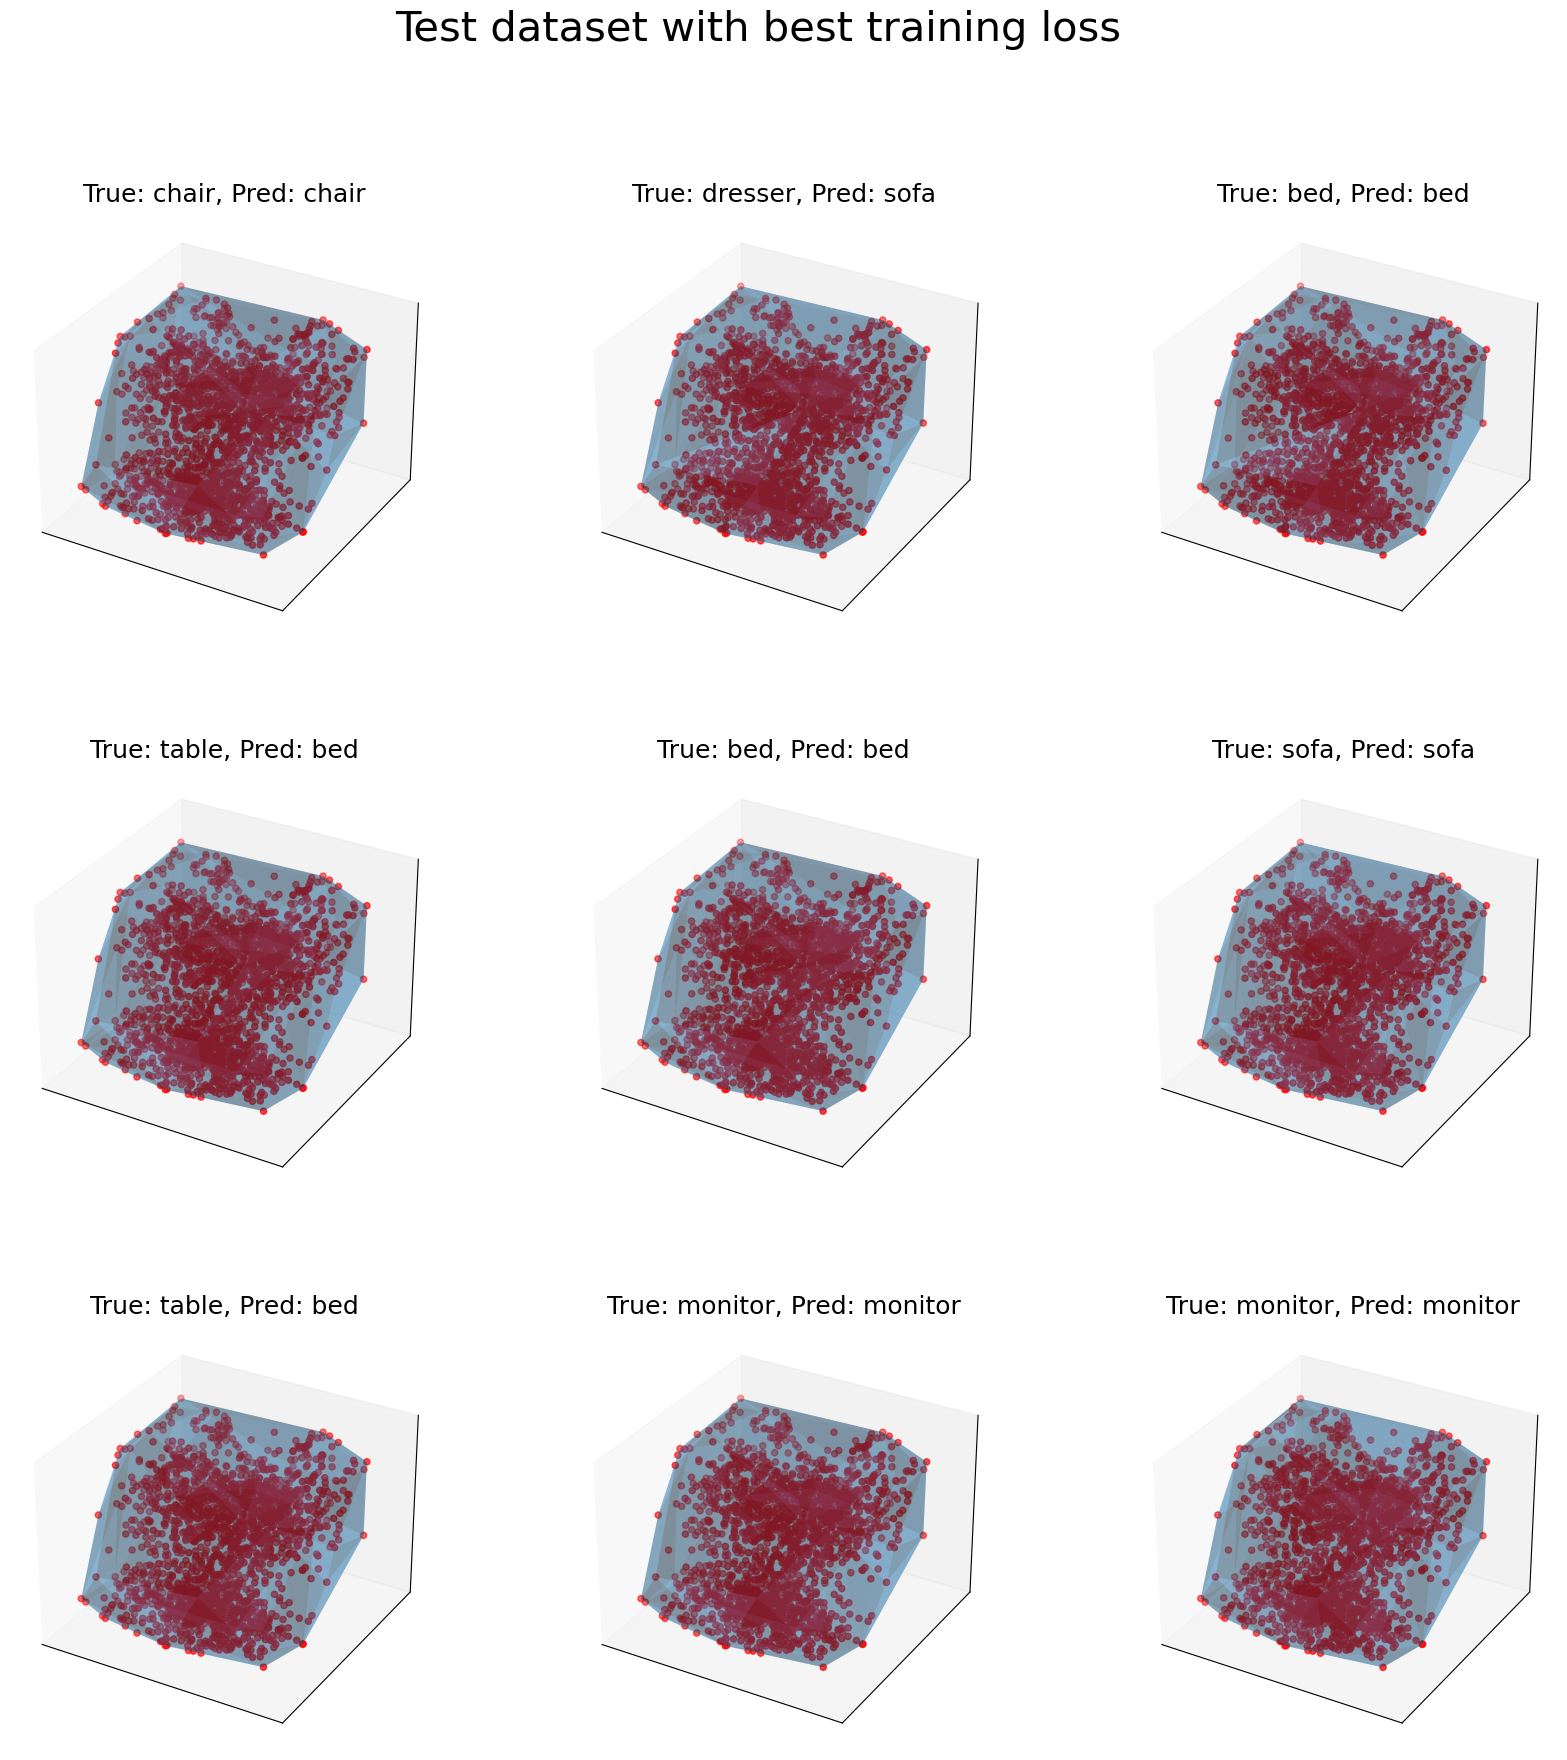

In [61]:
plot_images(data_test, test_labels, title = "Test dataset with best training loss", predictions=predictions)

In [62]:
torch.cuda.empty_cache()
gc.collect()

108677

#### Best model (validation error)

In [63]:
if(best_epoch_val == best_epoch_train):
    print(BOLD+GREEN+"The model with the best training error is the same of the model with the best validation error!"+END)
else:
    print(BOLD+RED+"The model with the best training error is not the same of the model with the best validation error!"+END)

The model with the best training error is not the same of the model with the best validation error!


In [64]:
best_model_val =  Net(num_classes=10).to(device)
best_model_val.load_state_dict(torch.load("model_bestVAL.pt"))
best_model_val.eval();

In [65]:
train_loss_final = []
val_loss_final = []

iterator =  tqdm(train_dataloader)
for sample in iterator:
    iterator.set_description("Final train loss")
    data = sample[0][0].float().to(device)
    edges = sample[1][0].long().to(device)
    labels = sample[2].float().to(device)

    out = best_model_val(data, edges)

    loss = loss_fn(labels[0], out)

    train_loss_final.append(loss.detach().cpu().numpy())
    
iterator =  tqdm(val_dataloader)
for sample in iterator:
    iterator.set_description("Final validation loss")
    data = sample[0][0].float().to(device)
    edges = sample[1][0].long().to(device)
    labels = sample[2].float().to(device)

    out = best_model_val(data, edges)

    loss = loss_fn(labels[0], out)

    val_loss_final.append(loss.detach().cpu().numpy())
        
print(BOLD+"FINAL AVERAGE TRAINING LOSS: "+END+str(np.mean(train_loss_final)))
print(BOLD+"FINAL AVERAGE VALIDATION LOSS: " +END+str(np.mean(val_loss_final))+"\n")

Final validation loss: 100%|███████████████████████████████████████████████████████| 1473/1473 [00:20<00:00, 72.63it/s]

FINAL AVERAGE TRAINING LOSS: 59981.36
FINAL AVERAGE VALIDATION LOSS: 82651.39



In [66]:
correct_train = np.zeros(len(train_labels))
predictions = []
losses_train = []

for i in trange(len(correct_train)):
    
    #"one-hot encoded"
    array = np.zeros(10)
    array[train_labels[i]] = 1000
    label = torch.tensor(array).float().to(device)
    
    out = best_model_val(torch.tensor(data_train[i]).float().to(device),torch.tensor(edge_train[i]).long().to(device))
    
    predictions.append(torch.argmax(out).item())
    
    loss = loss_fn(label, out)
    losses_train.append(loss.detach().cpu().numpy())
    
    if(train_labels[i] == torch.argmax(out).item()):
        correct_train[i] = 1

print(BOLD+"Train loss (without noisy data): " + END + str(np.array(losses_train).mean()))
print(BOLD+"Train accuracy: " + END + str(correct_train.mean()*100)+"%")

100%|██████████████████████████████████████████████████████████████████████████████| 3991/3991 [00:42<00:00, 93.13it/s]

Train loss (without noisy data): 1784175700.0
Train accuracy: 23.72838887496868%


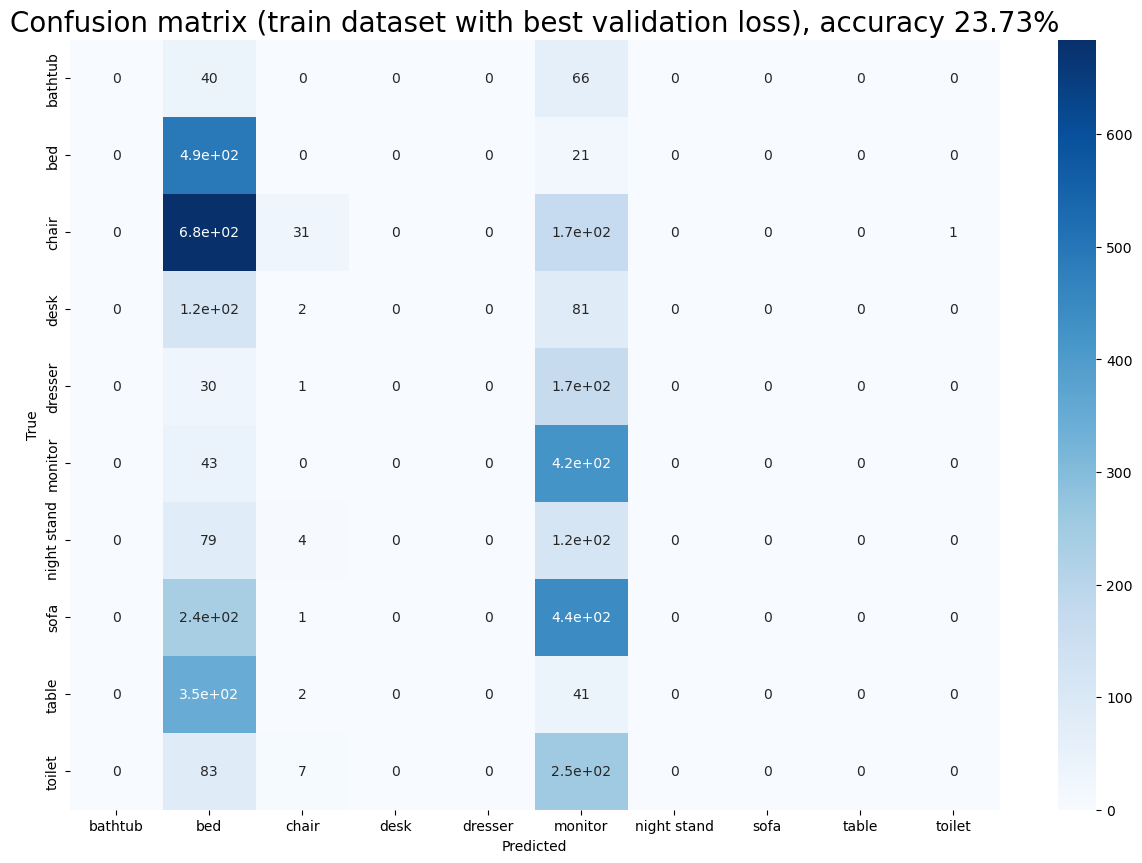

In [67]:
print_confusion_matrix_pandas(labels = train_labels, predictions = predictions, 
                              title = f"Confusion matrix (train dataset with best validation loss), accuracy {np.round(correct_train.mean()*100,2)}%")

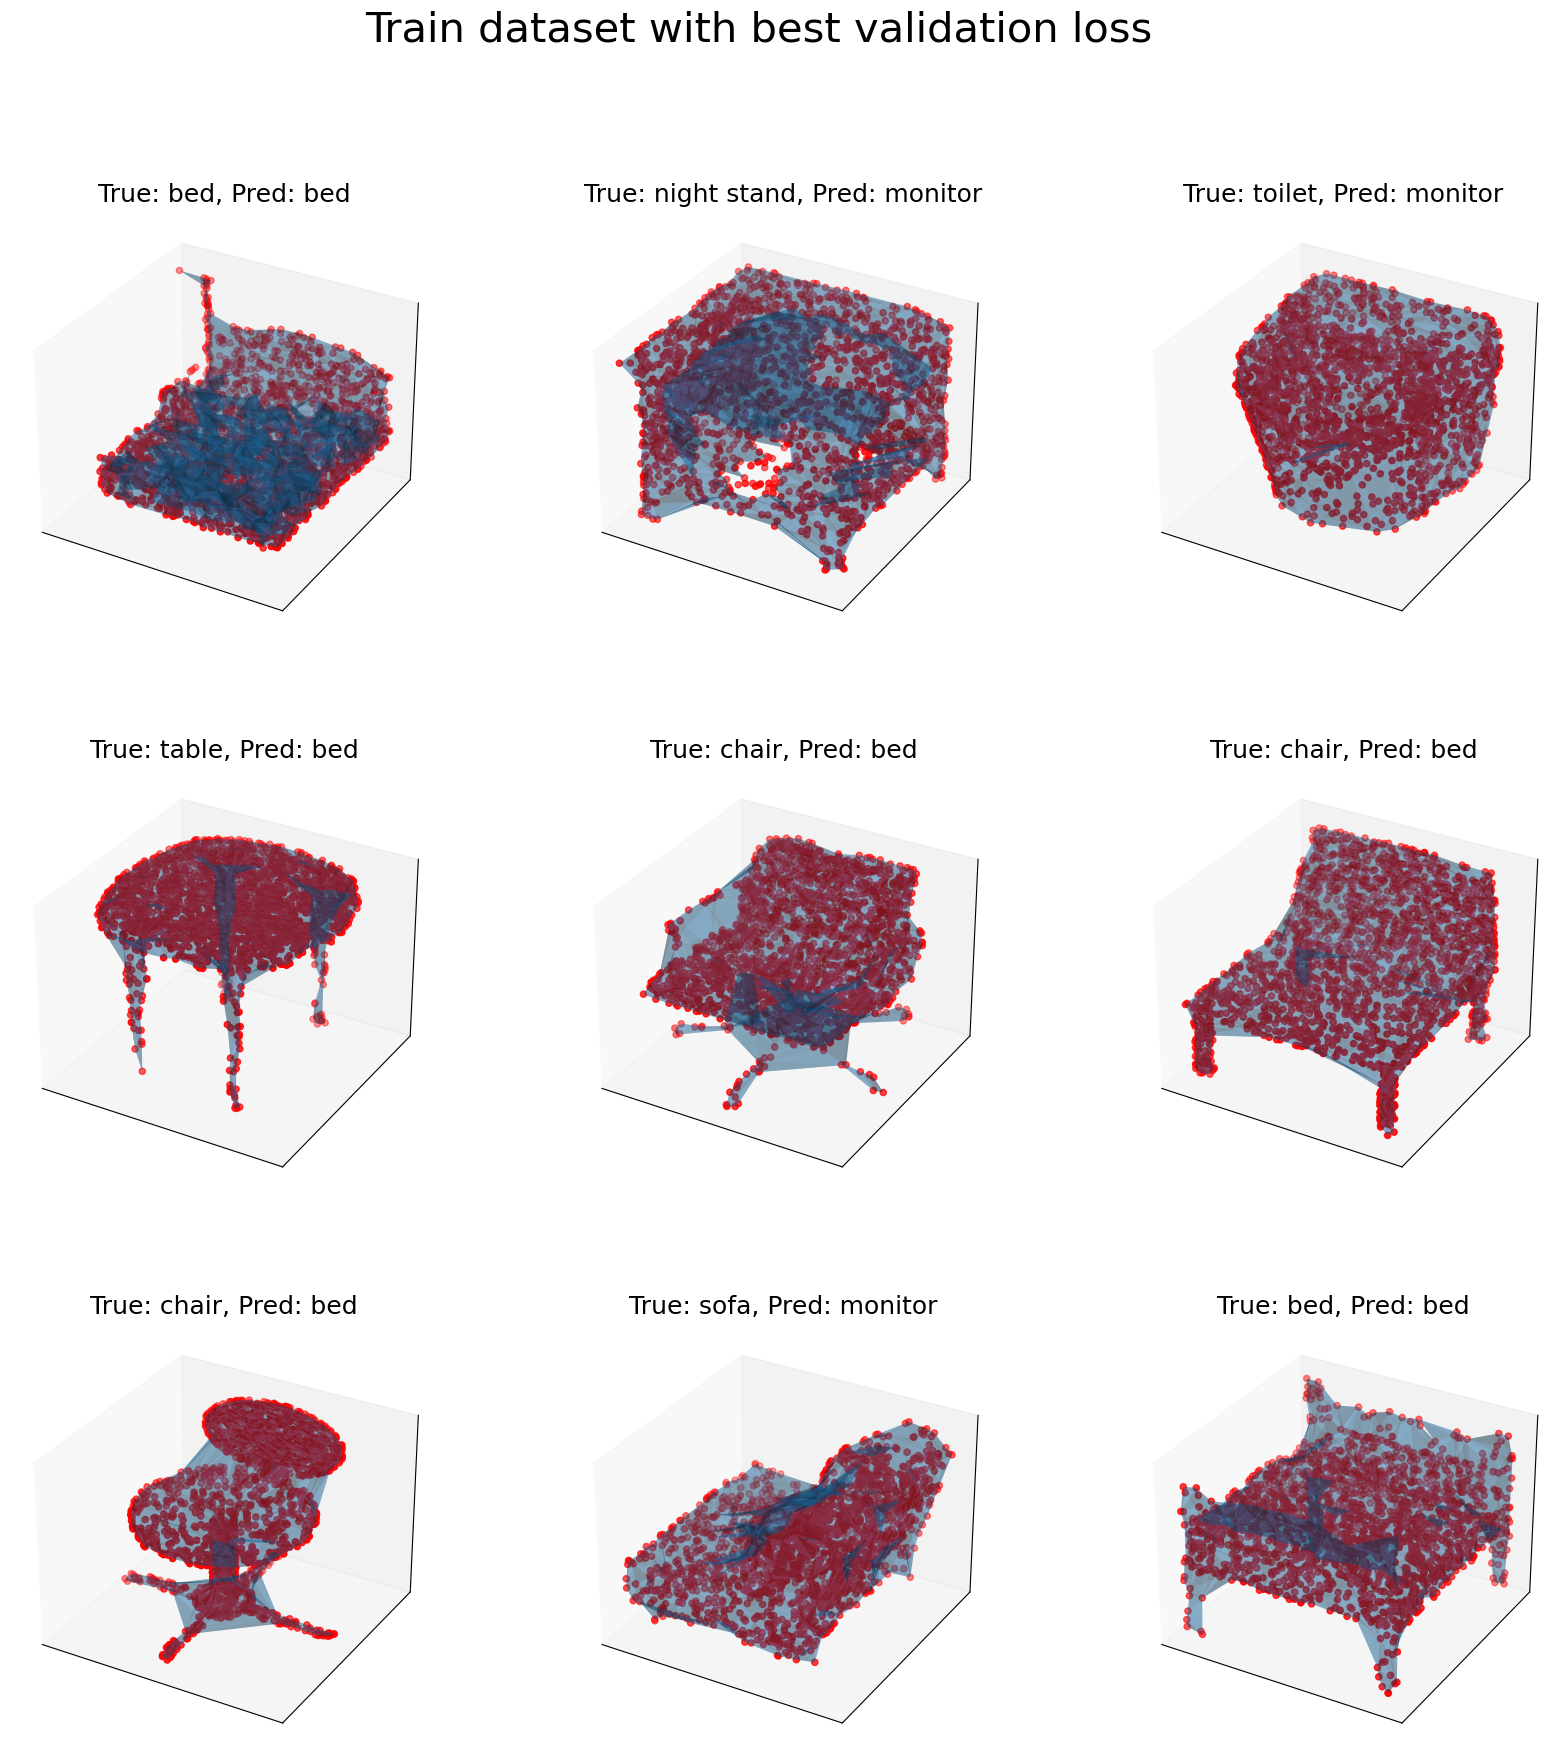

In [68]:
plot_images(data_train, train_labels, title = "Train dataset with best validation loss", predictions=predictions)

In [69]:
correct_test = np.zeros(len(test_labels))
predictions = []
losses_test = []

for i in trange(len(correct_test)):
    
    #"one-hot encoded"
    array = np.zeros(10)
    array[test_labels[i]] = 1000
    label = torch.tensor(array).float().to(device)
    
    out = best_model_val(torch.tensor(data_test[i]).float().to(device),torch.tensor(edge_test[i]).long().to(device))
    
    predictions.append(torch.argmax(out).item())
    
    loss = loss_fn(label, out)
    losses_test.append(loss.detach().cpu().numpy())
    
    if(test_labels[i] == torch.argmax(out).item()):
        correct_test[i] = 1

print(BOLD+"Test loss: " + END + str(np.array(losses_test).mean()))
print(BOLD+"Test accuracy: "+END+str(correct_test.mean()*100)+"%")

100%|████████████████████████████████████████████████████████████████████████████████| 908/908 [00:13<00:00, 67.92it/s]

Test loss: 78127.734
Test accuracy: 32.929515418502206%


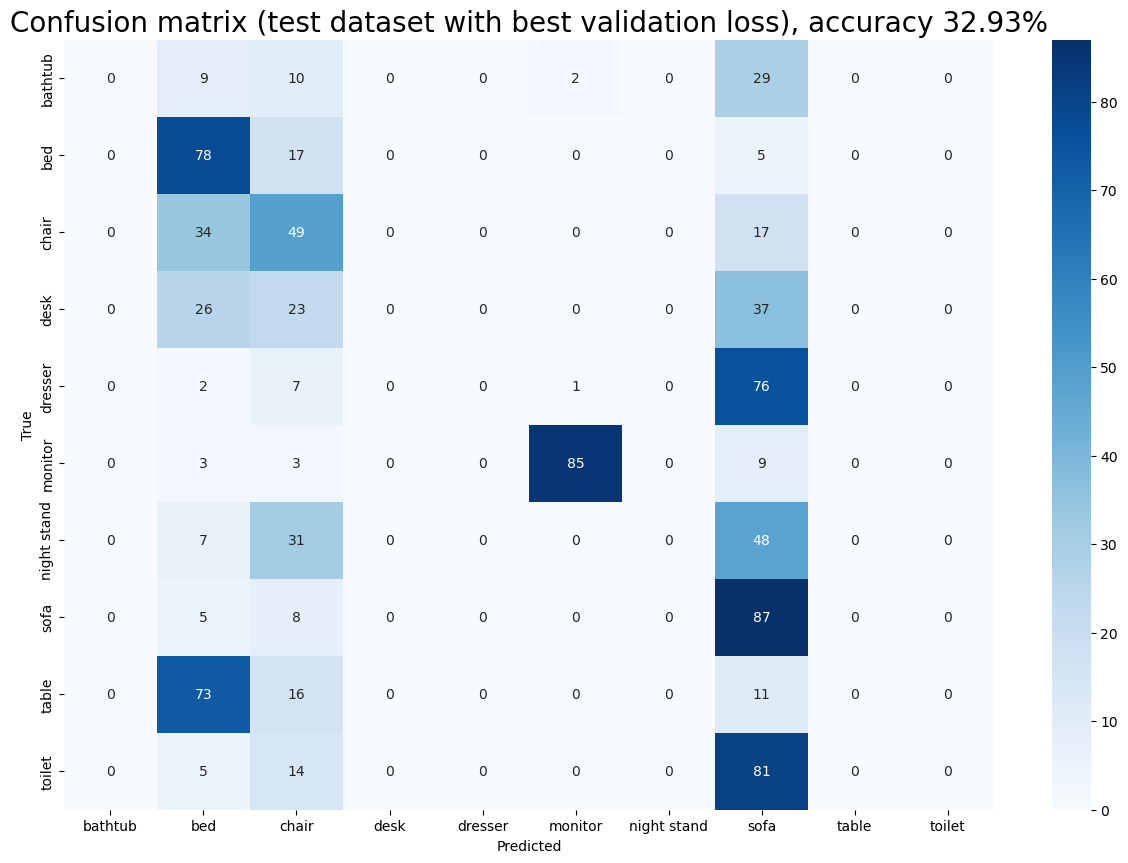

In [70]:
print_confusion_matrix_pandas(labels = test_labels, predictions = predictions, 
                              title = f"Confusion matrix (test dataset with best validation loss), accuracy {np.round(correct_test.mean()*100,2)}%")

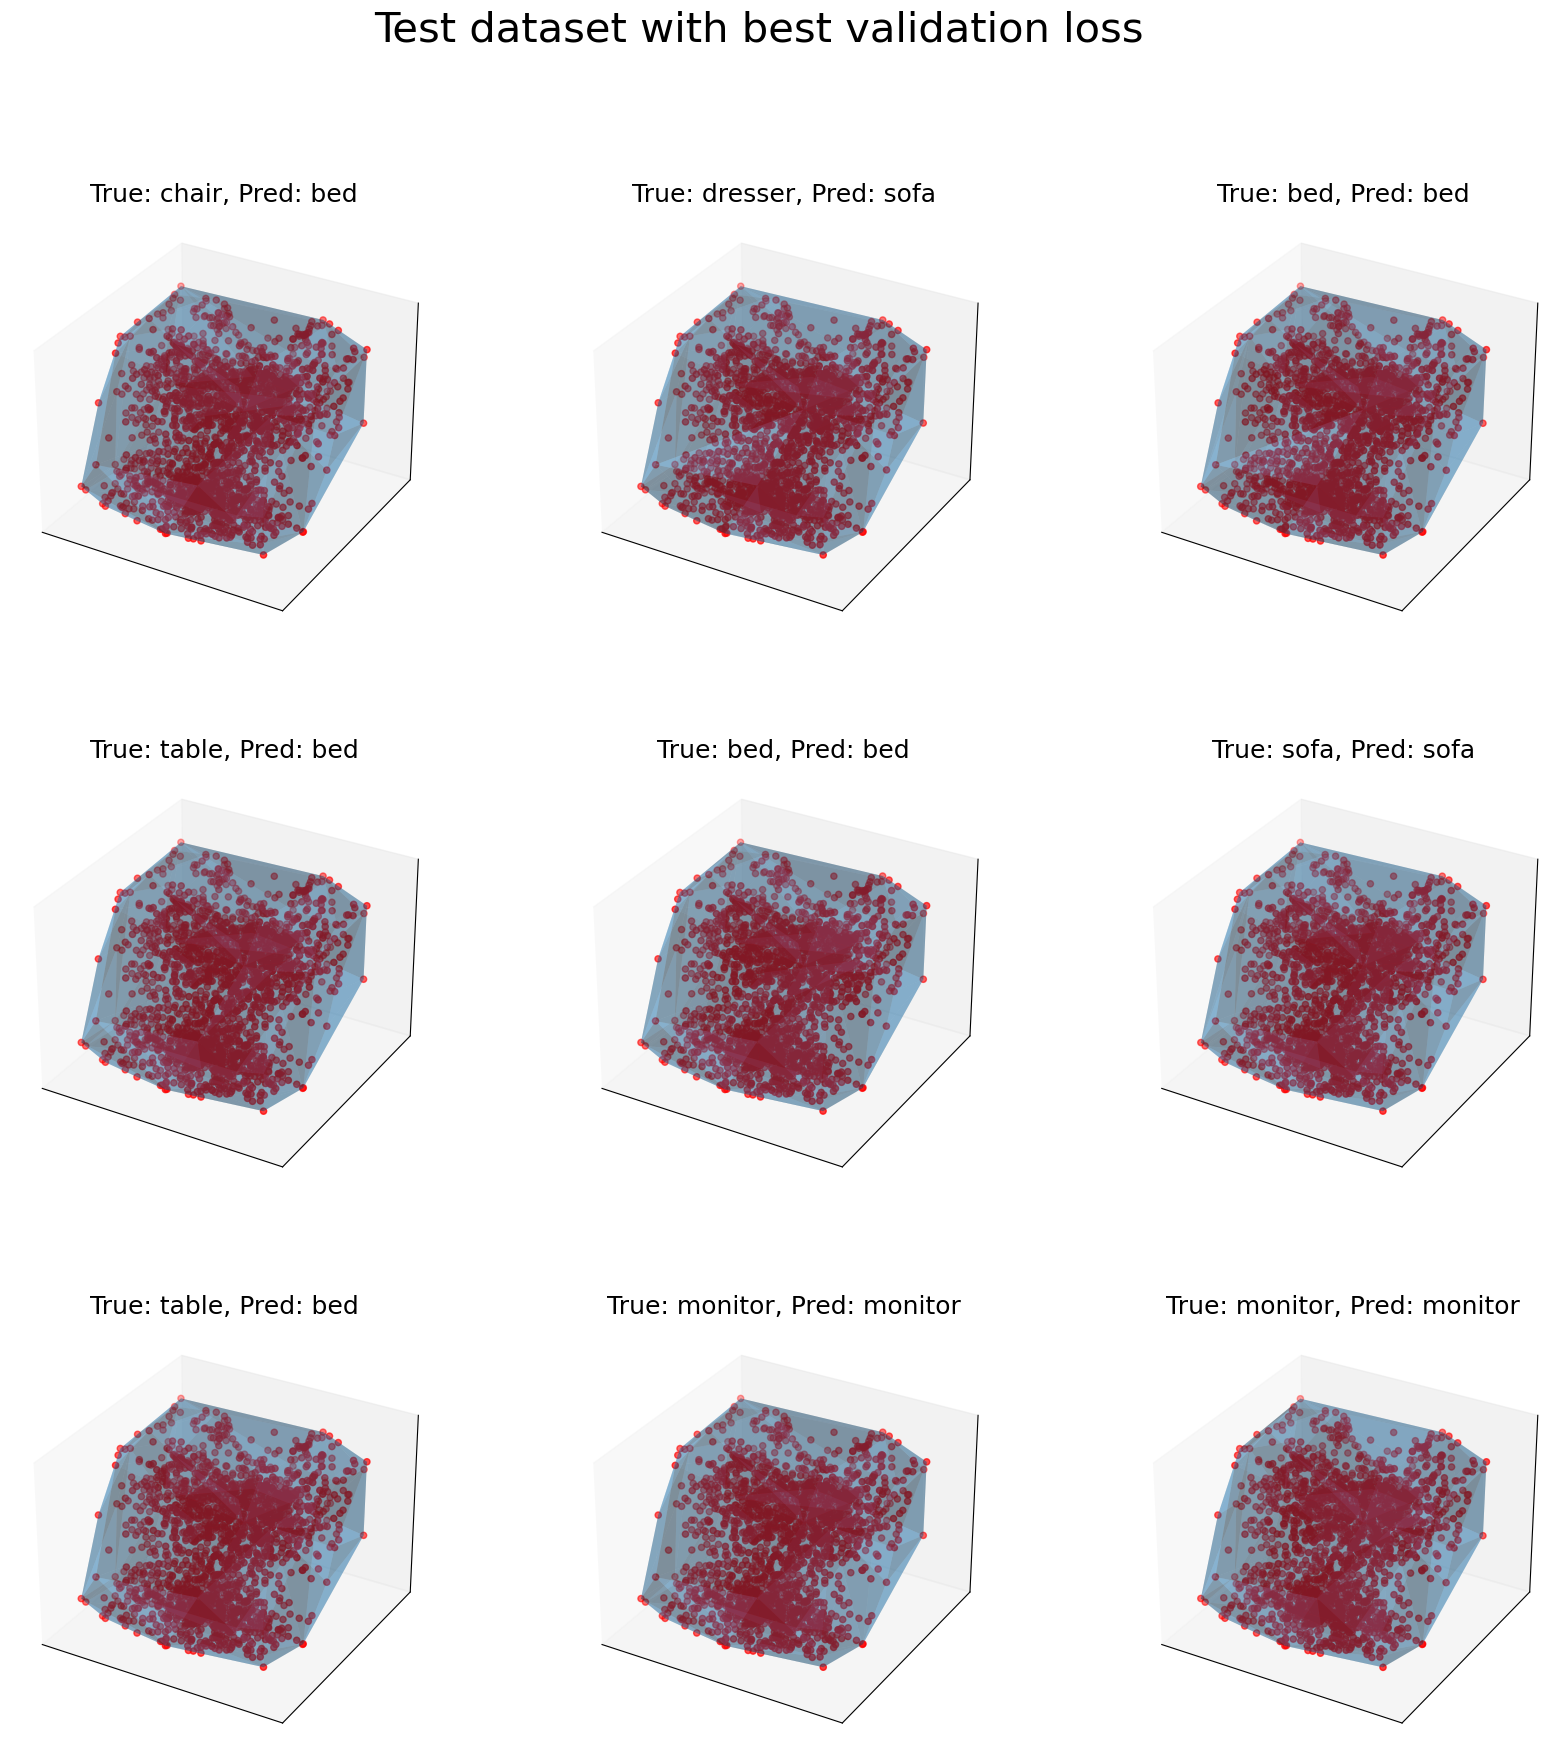

In [71]:
plot_images(data_test, test_labels, title = "Test dataset with best validation loss", predictions=predictions)

In [72]:
torch.cuda.empty_cache()
gc.collect()

108369

## PointNet

In [ ]:
data_train_noise = np.concatenate((data_train,data_train+np.random.uniform(-0.01,0.01, size = (len(data_train),2048,6))))
train_labels_noise = np.concatenate((train_labels,train_labels),axis=0)

In [ ]:
one_labels_train = []
for label in train_labels_noise: #with noise change to train_labels_noise 
    array = np.zeros(10)
    array[label] = 1
    one_labels_train.append(array)
    
n = 7000 

In [ ]:
class ListDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __getitem__(self, index):
        return torch.tensor(self.data[index]), torch.tensor(self.labels[index])

    def __len__(self):
        return len(self.data)

train_dataset = ListDataset(data_train_noise[0:n], one_labels_train[0:n])
val_dataset = ListDataset(data_train_noise[n:len(data_train_noise)], one_labels_train[n:len(data_train_noise)])


train_dataloader = DataLoader(train_dataset, batch_size = 35, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = 35, shuffle = False)

### Model Definition

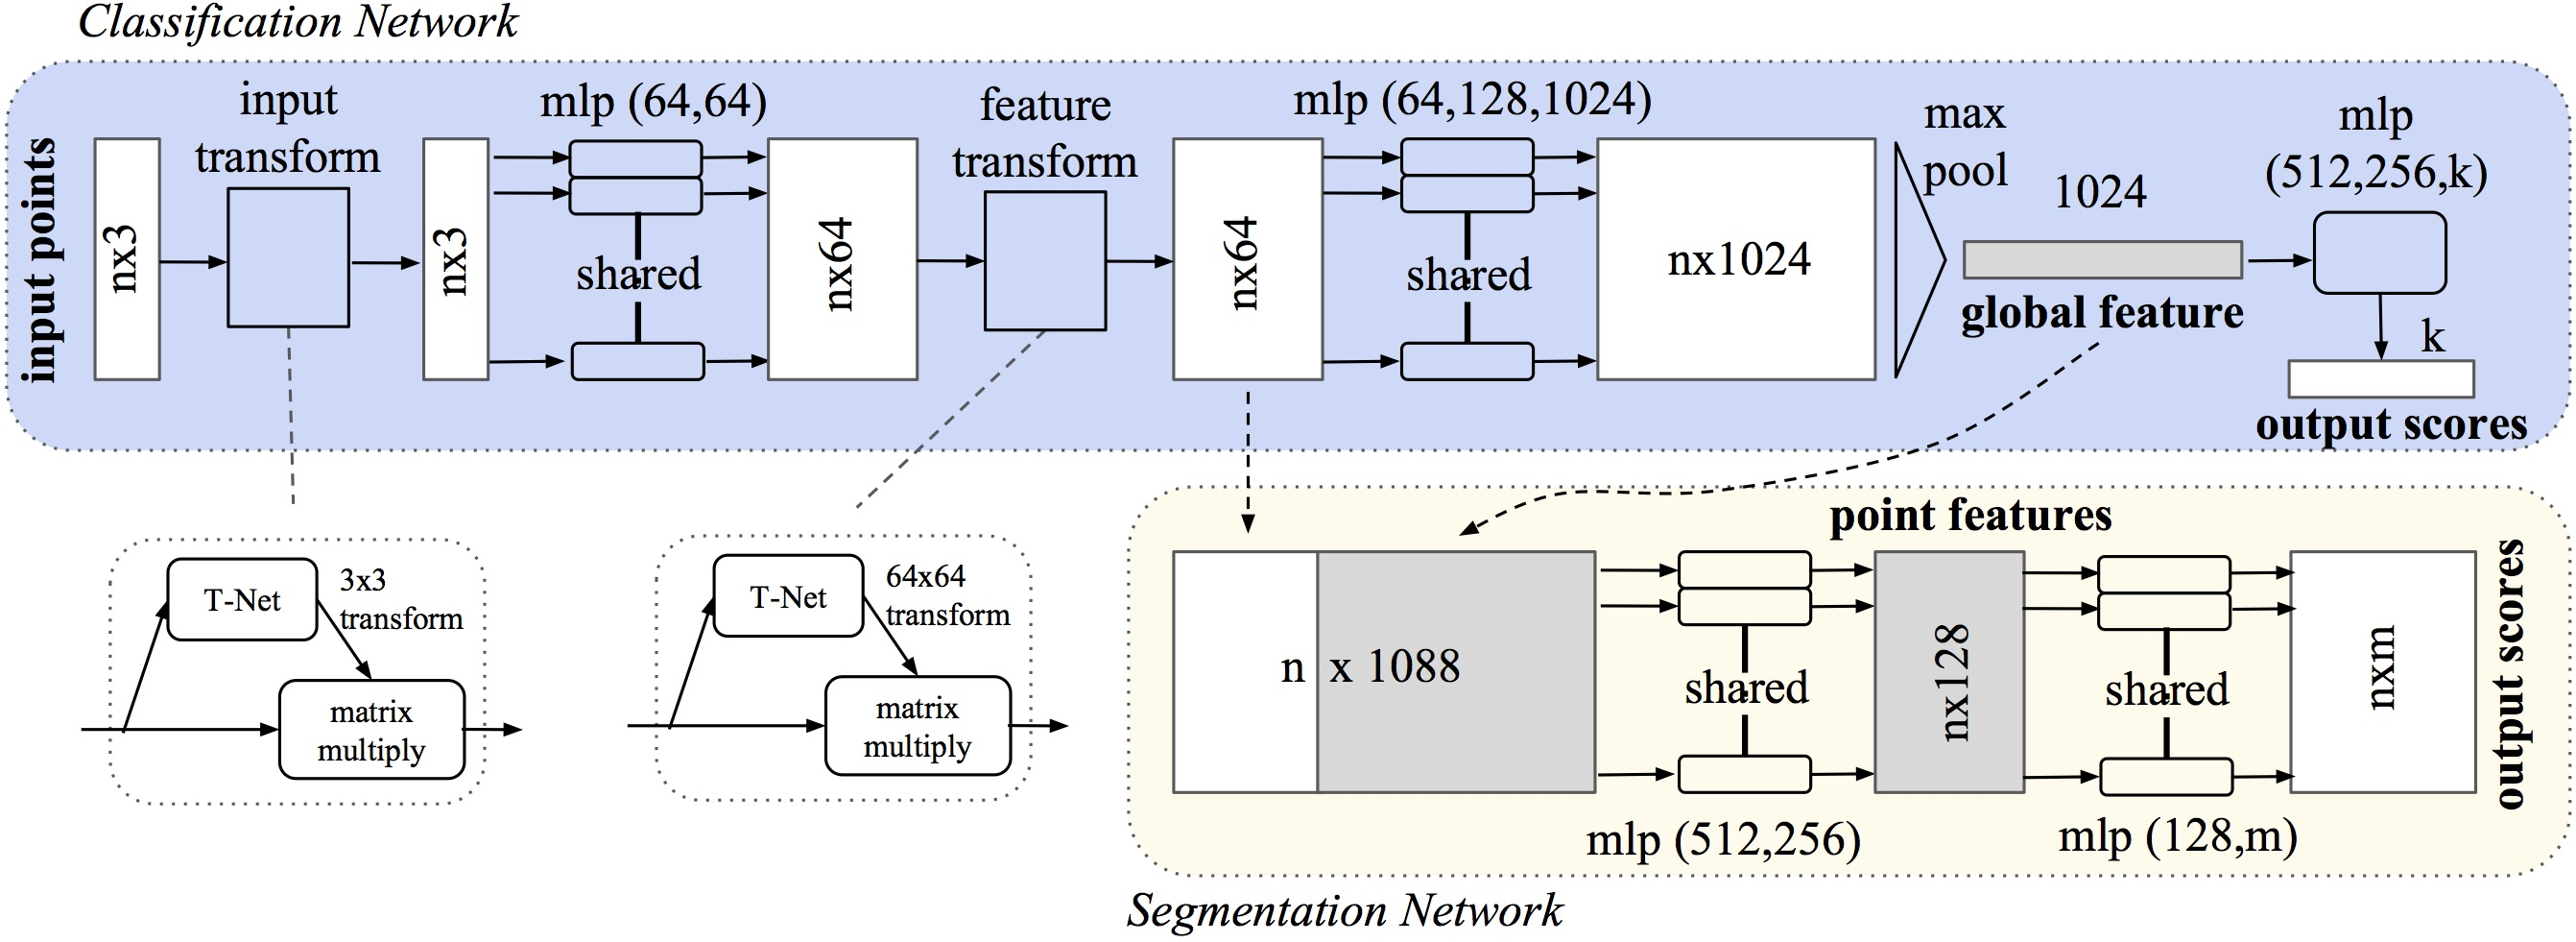

In [ ]:
class Tnet(nn.Module):
    def __init__(self, k=3):
        super().__init__()
        self.k=k
        self.conv1 = nn.Conv1d(k,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,k*k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)


    def forward(self, data):

        # input.shape == (bs,n,3)
        data = data.permute(0, 2, 1).to(device)###############
        bs = data.size(0)

        
        xb = F.relu(self.bn1(self.conv1(data)))
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten(1)(pool)
        xb = F.relu(self.bn4(self.fc1(flat)))
        xb = F.relu(self.bn5(self.fc2(xb)))

        #initialize as identity
        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
        if xb.is_cuda:
            init=init.cuda()
        matrix = self.fc3(xb).view(-1,self.k,self.k) + init
        return matrix

In [ ]:
class Transform(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=3)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(3,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)


        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)

    def forward(self, data):
        
        matrix3x3 = self.input_transform(data)
        # batch matrix multiplication
        
        xb = torch.bmm(data, matrix3x3).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))
        
        xb = xb.permute(0, 2, 1).to(device)
        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(xb, matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix3x3, matrix64x64

In [ ]:
class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.5)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, data):
        xb, matrix3x3, matrix64x64 = self.transform(data)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix3x3, matrix64x64

In [ ]:
def pointnetloss(outputs, labels, m3x3, m64x64, alpha = 0.01):
    criterion = nn.CrossEntropyLoss()
    bs=outputs.size(0)
    id3x3 = torch.eye(3, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id3x3=id3x3.cuda()
        id64x64=id64x64.cuda()
    diff3x3 = id3x3-torch.bmm(m3x3,m3x3.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff3x3)+torch.norm(diff64x64)) / float(bs)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pointnet =  PointNet().to(device)

print(BOLD+"You are working on: "+END+str(device))

### Training

In [ ]:
#training only if you decide to not load the model    
if(not LOAD_MODEL):
    
    num_epochs = 150
    


    #lists to store the trend of the learning procedure
    plot_train = []
    plot_val=[]


    best_epoch_val = 0
    prev_loss_val = np.inf

    best_epoch_train = 0
    prev_loss_train = np.inf

    count_epochs = 0 #counts the epoch since we consider the fact we can manually interrupct the 
                     #training procedure(used for the plots)
        
    optimizer = optim.RMSprop(pointnet.parameters(), lr=0.001, weight_decay=1e-2)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

    for epoch in range(num_epochs):

        print('#################')
        print(f'# EPOCH {epoch+1}')
        print('#################')



        #lists to store the trend of the learning procedure "in real time" at each epoch/batch
        train_loss = []
        val_loss = []

        ##############TRAINING##############

        pointnet.train()

        optimizer.zero_grad()

        iterator = tqdm(train_dataloader)    
        for sample in iterator:
            data = sample[0].to(device)
            labels = sample[1].float().to(device)
            
            outputs, m3x3, m64x64 = pointnet(data[:,:,0:3].type(torch.FloatTensor).to(device))
    
            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()


            optimizer.step()
            optimizer.zero_grad() 

            train_loss.append(loss.detach().cpu().numpy())

        gc.collect()


        plot_train.append(np.mean(train_loss))

        ##############VALIDATION##############

        pointnet.eval()
        iterator = tqdm(val_dataloader)
        for sample in iterator:
            iterator.set_description("Validation phase")
            data = sample[0].float().to(device)
            labels = sample[1].float().to(device)

            outputs, m3x3, m64x64 = pointnet(data[:,:,0:3].type(torch.FloatTensor).to(device))

            loss = pointnetloss(outputs, labels, m3x3, m64x64)

            val_loss.append(loss.detach().cpu().numpy())

        print(BOLD+"AVERAGE TRAINING LOSS: "+END+str(np.mean(train_loss)))
        print(BOLD+"AVERAGE VALIDATION LOSS: " +END+str(np.mean(val_loss))+"\n")

        plot_val.append(np.mean(val_loss))

        #saving the best model according to the training loss
        if np.mean(train_loss) < prev_loss_train:
            print(GREEN+"Saved Model: "+END+UNDERLINE+"best training error reached"+END)
            best_epoch_train = epoch + 1
            torch.save(pointnet.state_dict(), "pointnet_bestTRAIN.pt")
            prev_loss_train = np.mean(train_loss)


        #saving the best model according to the validation loss
        if np.mean(val_loss) < prev_loss_val:
            print(GREEN+"Saved Model: "+END+UNDERLINE+"best validation error reached\n\n"+END)
            best_epoch_val = epoch + 1
            torch.save(pointnet.state_dict(), "pointnet_bestVAL.pt")
            prev_loss_val = np.mean(val_loss)
            
            if(epoch + 1 != 1):
                scheduler.step() 
        else:
            print("\n\n")

        gc.collect()

        #next epoch
        count_epochs += 1

#### Saving the result or downloading of the model

Files:
* Results: https://www.dropbox.com/s/56ilxoqzy9skhpu/nndl_results_pointnet.zip?dl=1
* Pointnets: https://www.dropbox.com/s/612yq373xdg4xaz/pointnet_nndl.zip?dl=1

In [74]:
#saving the results into arrays
if(not LOAD_MODEL):
    
    np.save("./data/plot_train_pointnet.npy",np.array(plot_train))
    np.save("./data/plot_val_pointnet.npy",np.array(plot_val))
    np.save("./data/best_epochs_pointnet.npy",np.array([best_epoch_train,best_epoch_val,count_epochs]))
    np.save("./data/best_losses_pointnet.npy",np.array([prev_loss_train,prev_loss_val]))

#loading the results mantaining the same variable names
else:
    urllib.request.urlretrieve("https://www.dropbox.com/s/56ilxoqzy9skhpu/nndl_results_pointnet.zip?dl=1", "nndl_results_pointnet.zip")
    urllib.request.urlretrieve("https://www.dropbox.com/s/612yq373xdg4xaz/pointnet_nndl.zip?dl=1", "pointnet_nndl.zip")
       
    with zipfile.ZipFile("nndl_results_pointnet.zip", 'r') as zip_ref:
        zip_ref.extractall("./data/")
    
    with zipfile.ZipFile("pointnet_nndl.zip", 'r') as zip_ref:
        zip_ref.extractall("./")
    
    plot_train = np.load("data/plot_train_pointnet.npy",allow_pickle=True)
    plot_val = np.load("data/plot_val_pointnet.npy",allow_pickle=True)
    best_epochs = np.load("data/best_epochs_pointnet.npy",allow_pickle=True) 
    best_losses = np.load("data/best_losses_pointnet.npy",allow_pickle=True)
    
    best_epoch_train = best_epochs[0]
    best_epoch_val = best_epochs[1]
    count_epochs = best_epochs[2]
    
    prev_loss_train = best_losses[0]
    prev_loss_val = best_losses[1]

#### Plot of the losses

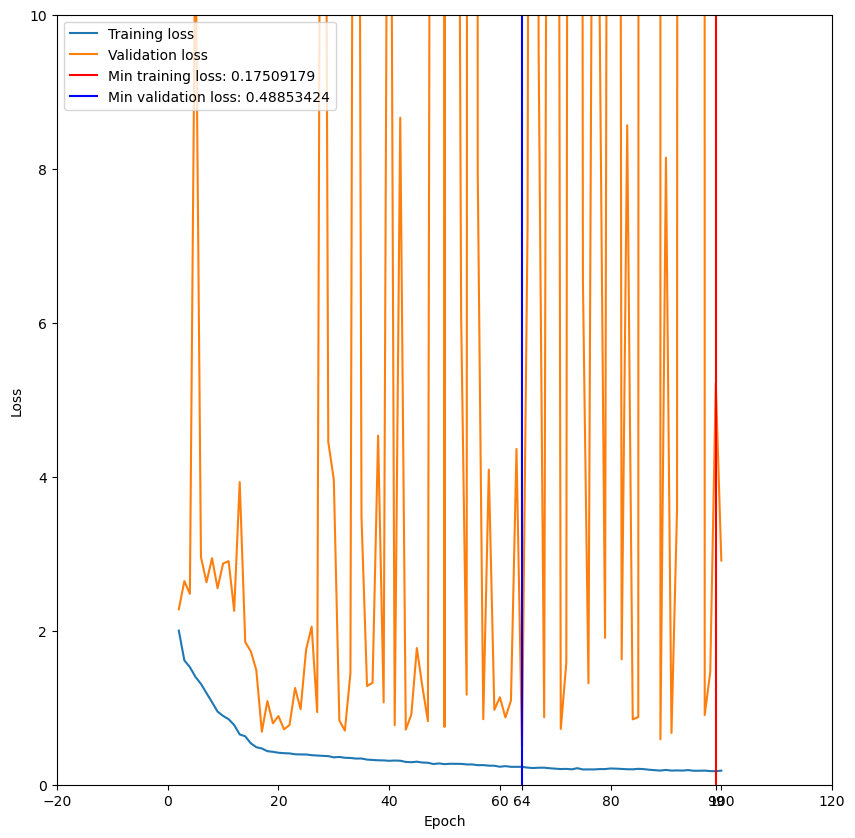

In [82]:
#generating the batch indexes
batchID = np.array([i for i in range(count_epochs)])+np.ones(count_epochs)

plt.figure(figsize=(10,10))

#plotting the losses
#plt.yscale('log')
plt.plot(batchID[1:],plot_train[1:],label = "Training loss")
plt.plot(batchID[1:],plot_val[1:], label = "Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.ylim(top = 10, bottom = 0)

#showing the position of the best values
plt.axvline(x = best_epoch_train+0.02, color = 'r', label = "Min training loss: "+str(prev_loss_train))
plt.axvline(x = best_epoch_val-0.02, color = 'b', label = "Min validation loss: "+str(prev_loss_val))

#adding the position of the best values in the x axis
ticks = list(plt.xticks()[0]) 
ticks.extend([best_epoch_train,best_epoch_val])
plt.xticks(ticks)

plt.legend()

#saving the figure
plt.savefig("Training procedure PointNet")
plt.show()

In [ ]:
torch.cuda.empty_cache()
gc.collect()

### Testing and final results

#### Best PointNet (Training Error)

In [ ]:
best_model_train = PointNet().to(device)
best_model_train.load_state_dict(torch.load("pointnet_bestTRAIN.pt"))
best_model_train.eval();

In [ ]:
train_loss_final = []
val_loss_final = []

iterator =  tqdm(train_dataloader)
for sample in iterator:
    iterator.set_description("Final train loss")
    data = sample[0].float().to(device)
    labels = sample[1].float().to(device)

    outputs, m3x3, m64x64 = best_model_train(data[:,:,0:3].type(torch.FloatTensor).to(device))

    loss = pointnetloss(outputs, labels, m3x3, m64x64)

    train_loss_final.append(loss.detach().cpu().numpy())
    
iterator =  tqdm(val_dataloader)
for sample in iterator:
    iterator.set_description("Final validation loss")
    data = sample[0].float().to(device)
    labels = sample[1].float().to(device)

    outputs, m3x3, m64x64 = best_model_train(data[:,:,0:3].type(torch.FloatTensor).to(device))

    loss = pointnetloss(outputs, labels, m3x3, m64x64)

    val_loss_final.append(loss.detach().cpu().numpy())
        
print(BOLD+"FINAL AVERAGE TRAINING LOSS: "+END+str(np.mean(train_loss_final)))
print(BOLD+"FINAL AVERAGE VALIDATION LOSS: " +END+str(np.mean(val_loss_final))+"\n")

In [ ]:
correct_train = np.zeros(len(train_labels))
predictions = []
losses_train = []

for i in trange(len(correct_train)):
    
    #"one-hot encoded"
    array = np.zeros(10)
    array[train_labels[i]] = 1
    label = torch.tensor(array).float().to(device)
    
    outputs, m3x3, m64x64 = best_model_train(torch.tensor(data_train[i,:,0:3]).reshape(1,2048,3).float().to(device))
    
    predictions.append(torch.argmax(outputs).item())
    
    loss = pointnetloss(outputs, label.reshape(1,10), m3x3, m64x64)
    losses_train.append(loss.detach().cpu().numpy())
    
    if(train_labels[i] == torch.argmax(outputs).item()):
        correct_train[i] = 1
        
print(BOLD+"Train loss (without noisy data): " + END + str(np.array(losses_train).mean()))
print(BOLD+"Train accuracy: " + END + str(correct_train.mean()*100)+"%")

In [ ]:
print_confusion_matrix_pandas(labels = train_labels, predictions = predictions, 
                              title = f"Confusion matrix of PointNet (train dataset with best training loss), accuracy {np.round(correct_train.mean()*100,2)}%")

In [ ]:
plot_images(data_train, train_labels, title = "Train dataset with best training loss (Pointnet)", predictions=predictions)

In [ ]:
correct_test = np.zeros(len(test_labels))
predictions = []
losses_test = []

for i in trange(len(correct_test)):
    
    #"one-hot encoded"
    array = np.zeros(10)
    array[test_labels[i]] = 1
    label = torch.tensor(array).float().to(device)
    
    outputs, m3x3, m64x64 = best_model_train(torch.tensor(data_test[i,:,0:3]).reshape(1,2048,3).float().to(device))
    
    predictions.append(torch.argmax(outputs).item())
    
    loss = pointnetloss(outputs, label.reshape(1,10), m3x3, m64x64)
    losses_test.append(loss.detach().cpu().numpy())
    
    if(test_labels[i] == torch.argmax(outputs).item()):
        correct_test[i] = 1
        
print(BOLD+"Test loss: " + END + str(np.array(losses_test).mean()))
print(BOLD+"Test accuracy: " + END + str(correct_test.mean()*100)+"%")

In [ ]:
print_confusion_matrix_pandas(labels = test_labels, predictions = predictions, 
                              title = f"Confusion matrix of PointNet (test dataset with best training loss), accuracy {np.round(correct_test.mean()*100,2)}%")

In [ ]:
plot_images(data_test, test_labels, title = "Test dataset with best training loss (PointNet)", predictions=predictions)

In [ ]:
torch.cuda.empty_cache()
gc.collect()

#### Best PointNet (Validartion Error)

In [ ]:
best_model_val =  PointNet().to(device)
best_model_val.load_state_dict(torch.load("pointnet_bestVAL.pt"))
best_model_val.eval();

In [ ]:
train_loss_final = []
val_loss_final = []

iterator =  tqdm(train_dataloader)
for sample in iterator:
    iterator.set_description("Final train loss")
    data = sample[0].float().to(device)
    labels = sample[1].float().to(device)

    outputs, m3x3, m64x64 = best_model_val(data[:,:,0:3].type(torch.FloatTensor).to(device))

    loss = pointnetloss(outputs, labels, m3x3, m64x64)

    train_loss_final.append(loss.detach().cpu().numpy())
    
iterator =  tqdm(val_dataloader)
for sample in iterator:
    iterator.set_description("Final validation loss")
    data = sample[0].float().to(device)
    labels = sample[1].float().to(device)

    outputs, m3x3, m64x64 = best_model_val(data[:,:,0:3].type(torch.FloatTensor).to(device))

    loss = pointnetloss(outputs, labels, m3x3, m64x64)

    val_loss_final.append(loss.detach().cpu().numpy())
        
print(BOLD+"FINAL AVERAGE TRAINING LOSS: "+END+str(np.mean(train_loss_final)))
print(BOLD+"FINAL AVERAGE VALIDATION LOSS: " +END+str(np.mean(val_loss_final))+"\n")

In [ ]:
correct_train = np.zeros(len(train_labels))
predictions = []
losses_train = []

for i in trange(len(correct_train)):
    
    #"one-hot encoded"
    array = np.zeros(10)
    array[train_labels[i]] = 1
    label = torch.tensor(array).float().to(device)
    
    outputs, m3x3, m64x64 = best_model_val(torch.tensor(data_train[i,:,0:3]).reshape(1,2048,3).float().to(device))
    
    predictions.append(torch.argmax(outputs).item())
    
    loss = pointnetloss(outputs, label.reshape(1,10), m3x3, m64x64)
    losses_train.append(loss.detach().cpu().numpy())
    
    if(train_labels[i] == torch.argmax(outputs).item()):
        correct_train[i] = 1
        
print(BOLD+"Train loss: " + END + str(np.array(losses_train).mean()))
print(BOLD+"Train accuracy: " + END + str(correct_train.mean()*100)+"%")

In [ ]:
print_confusion_matrix_pandas(labels = train_labels, predictions = predictions, 
                              title = f"Confusion matrix of PointNet (train dataset with best validation loss), accuracy {np.round(correct_train.mean()*100,2)}%")

In [ ]:
plot_images(data_train, train_labels, title = "Train dataset with best validation loss (Pointnet)", predictions=predictions)

In [ ]:
correct_test = np.zeros(len(test_labels))
predictions = []
losses_test = []

for i in trange(len(correct_test)):
    
    #"one-hot encoded"
    array = np.zeros(10)
    array[test_labels[i]] = 1
    label = torch.tensor(array).float().to(device)
    
    outputs, m3x3, m64x64 = best_model_val(torch.tensor(data_test[i,:,0:3]).reshape(1,2048,3).float().to(device))
    
    predictions.append(torch.argmax(outputs).item())
    
    loss = pointnetloss(outputs, label.reshape(1,10), m3x3, m64x64)
    losses_test.append(loss.detach().cpu().numpy())
    
    if(test_labels[i] == torch.argmax(outputs).item()):
        correct_test[i] = 1
        
print(BOLD+"Test loss (without noisy data): " + END + str(np.array(losses_test).mean()))
print(BOLD+"Test accuracy: " + END + str(correct_test.mean()*100)+"%")

In [ ]:
print_confusion_matrix_pandas(labels = test_labels, predictions = predictions, 
                              title = f"Confusion matrix of PointNet (test dataset with best validation loss), accuracy {np.round(correct_test.mean()*100,2)}%")

In [ ]:
plot_images(data_test, test_labels, title = "Test dataset with best validation loss (PointNet)", predictions=predictions)

In [ ]:
torch.cuda.empty_cache()
gc.collect()